In [247]:
%load_ext watermark
%watermark -a "Romell D.Z." -u -d -p numpy,pandas,matplotlib,seaborn,statsmodels

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Romell D.Z. 
last updated: 2018-11-25 

numpy 1.15.4
pandas 0.23.4
matplotlib 2.2.2
seaborn 0.9.0
statsmodels 0.10.0.dev0+3261eea


In [248]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns
sns.set('notebook')
from __future__ import division
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
%config InlineBackend.figure_format = 'retina'

In [249]:
def clean_dataframe(df):
    df.dropna(axis=1,how='all',inplace=True)
    columns_navalue =  df.columns[df.isna().any()].tolist()
    if columns_navalue != []:
        df.ix[-1,columns_navalue] = df[columns_navalue].median()
        df[columns_navalue] = df[columns_navalue].interpolate()
        
def plot_df(df,title ='Tourist'):
    df = df.T
    dic = dict(y='Region',x='Amount')
    info = df.sum().to_frame().reset_index()
    info.columns = list(dic.values())
    ax = sns.barplot(data=info,**dic)
    for i, v in enumerate(info['Amount'].values):
        ax.text( v+v*.1 ,i+.2 , str('%.3fM'%(v/1000)), color='black', fontweight='bold')
    plt.xscale('log')
    xx, locs = plt.xticks()
    ll = ['{:,}'.format(a) for a in xx]
    plt.xticks(xx[:-1], ll[:-1])
        
def show_descriptive_data(name_file,sheet,scale='symlog',title ='Tourist'):
    df = pd.read_excel(name_file,sheet_name=sheet,nrows=25,
                           skiprows=3,index_col=0,)
    df = df.loc[:,df.columns.map(lambda x: x.isalnum())]
    clean_dataframe(df)
    plot_df(df,title)
    plt.xscale(scale)
    plt.title(title)
    plt.show();

In [250]:
def plot_df_byYear(df):
    df = df.T.drop('Lima',1)
    df.index = pd.to_datetime(df.index)
    fig = plt.figure()
    ax = plt.subplot(111)
    df.plot(ax=ax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    ax.set_ylabel('Amount')
    ax.set_yscale('log');
        
def show_descriptive_data_byYear(name_file,sheet):
    df = pd.read_excel(name_file,sheet_name=sheet,nrows=25,
                           skiprows=3,index_col=0,)
    df = df.loc[:,df.columns.map(lambda x: x.isalnum())]
    clean_dataframe(df)
    plot_df_byYear(df)

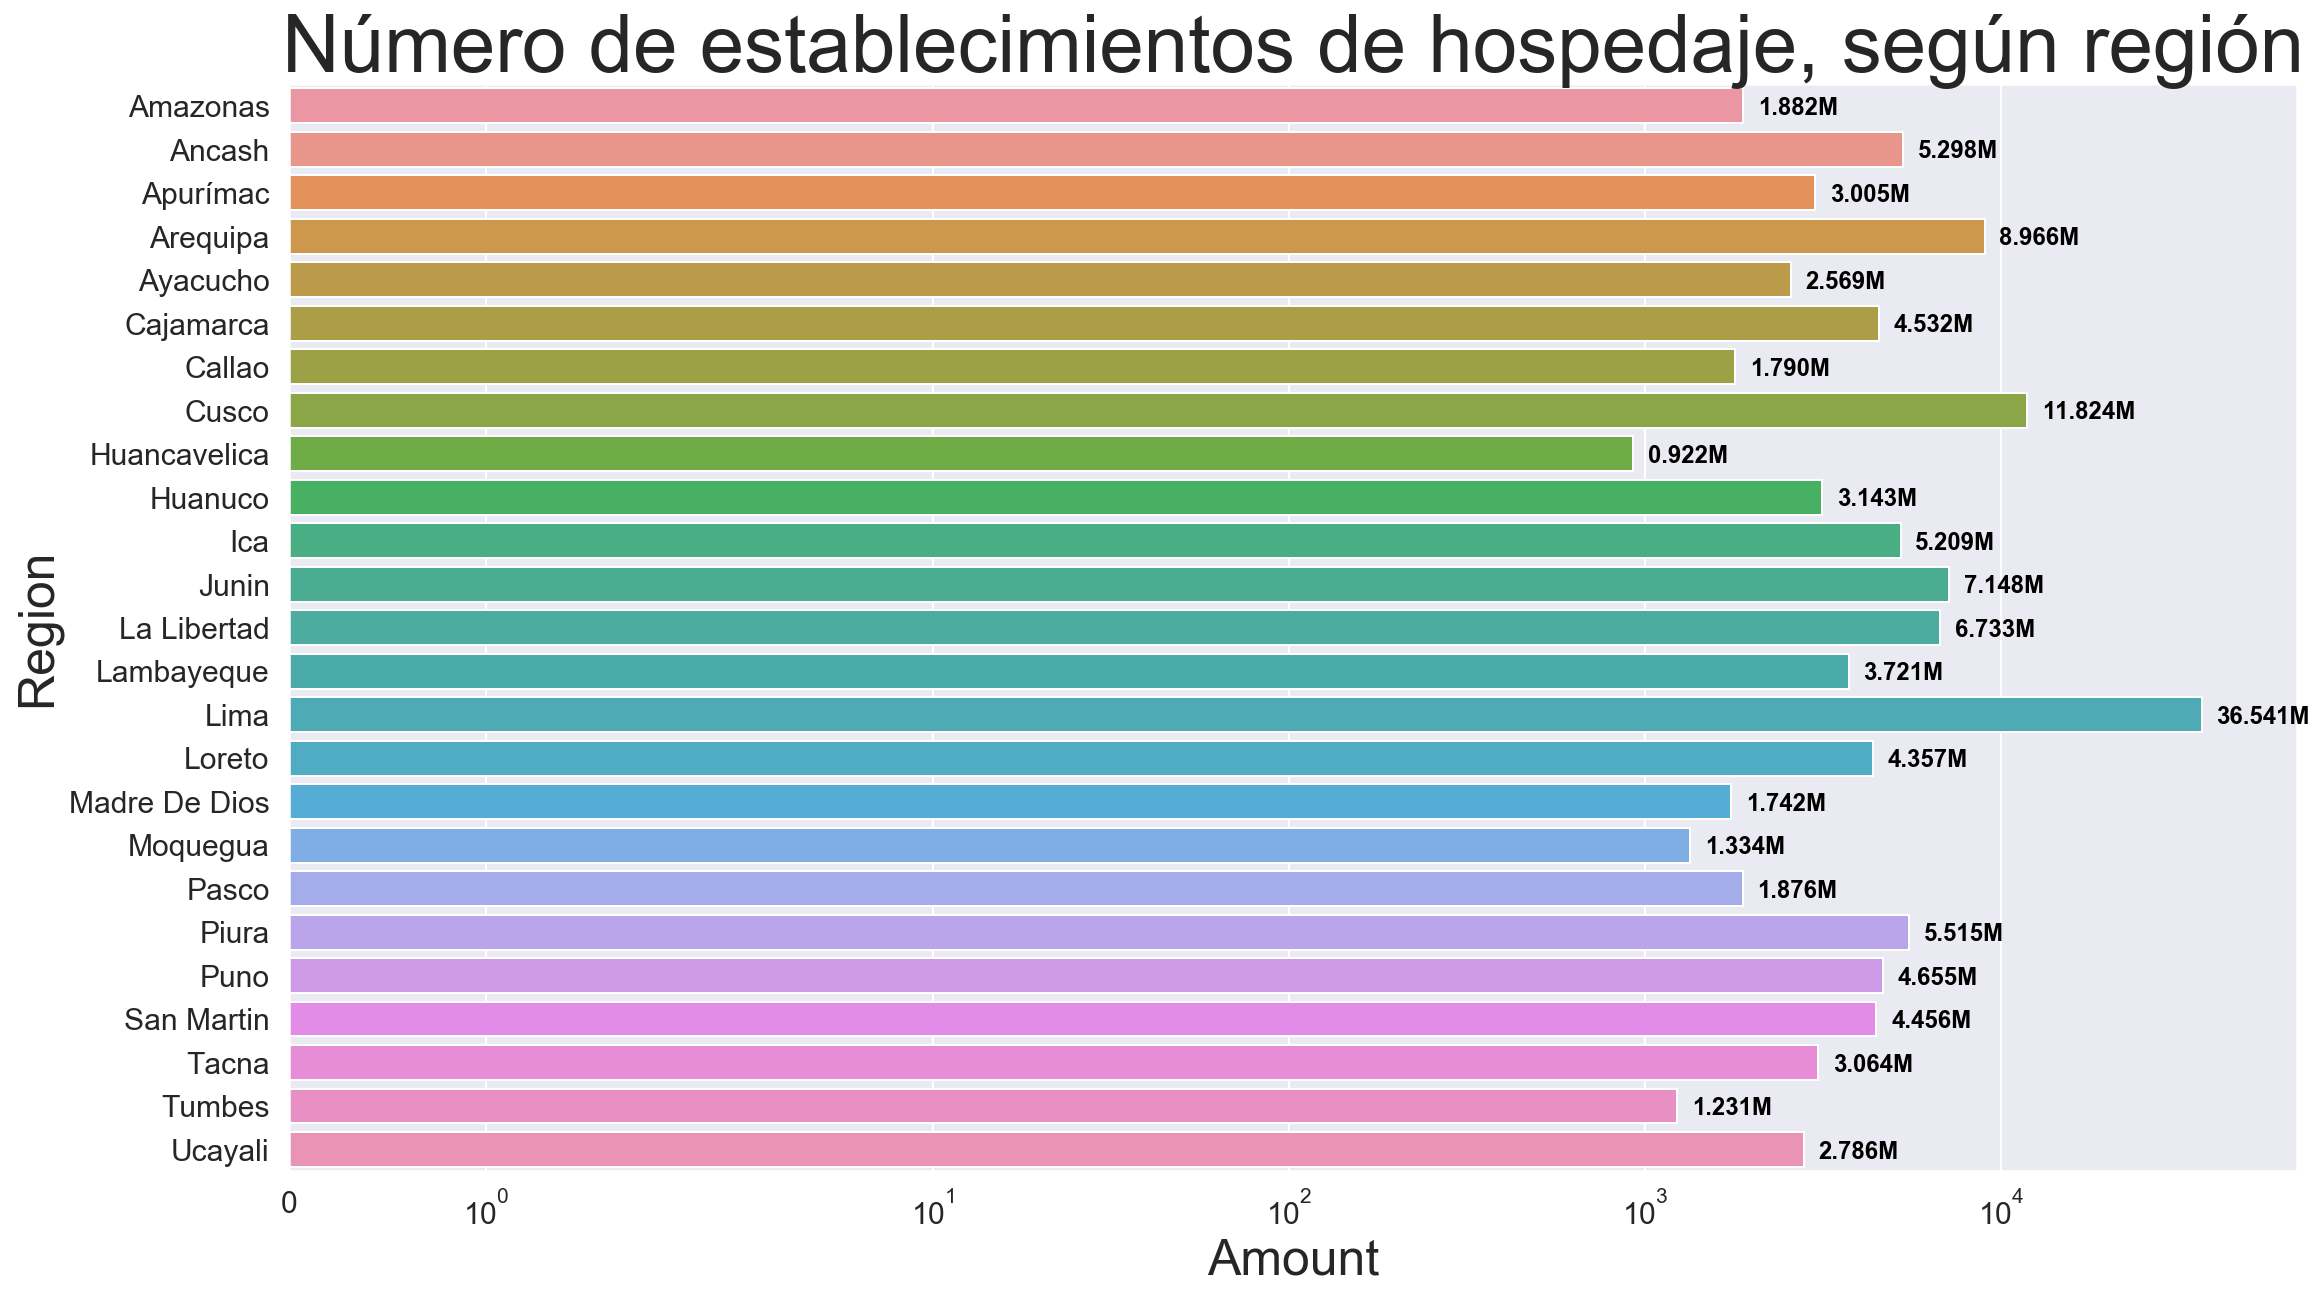

In [251]:
show_descriptive_data('rptaniomes_a.xls','rptaniomes',
                      title='Número de establecimientos de hospedaje, según región')

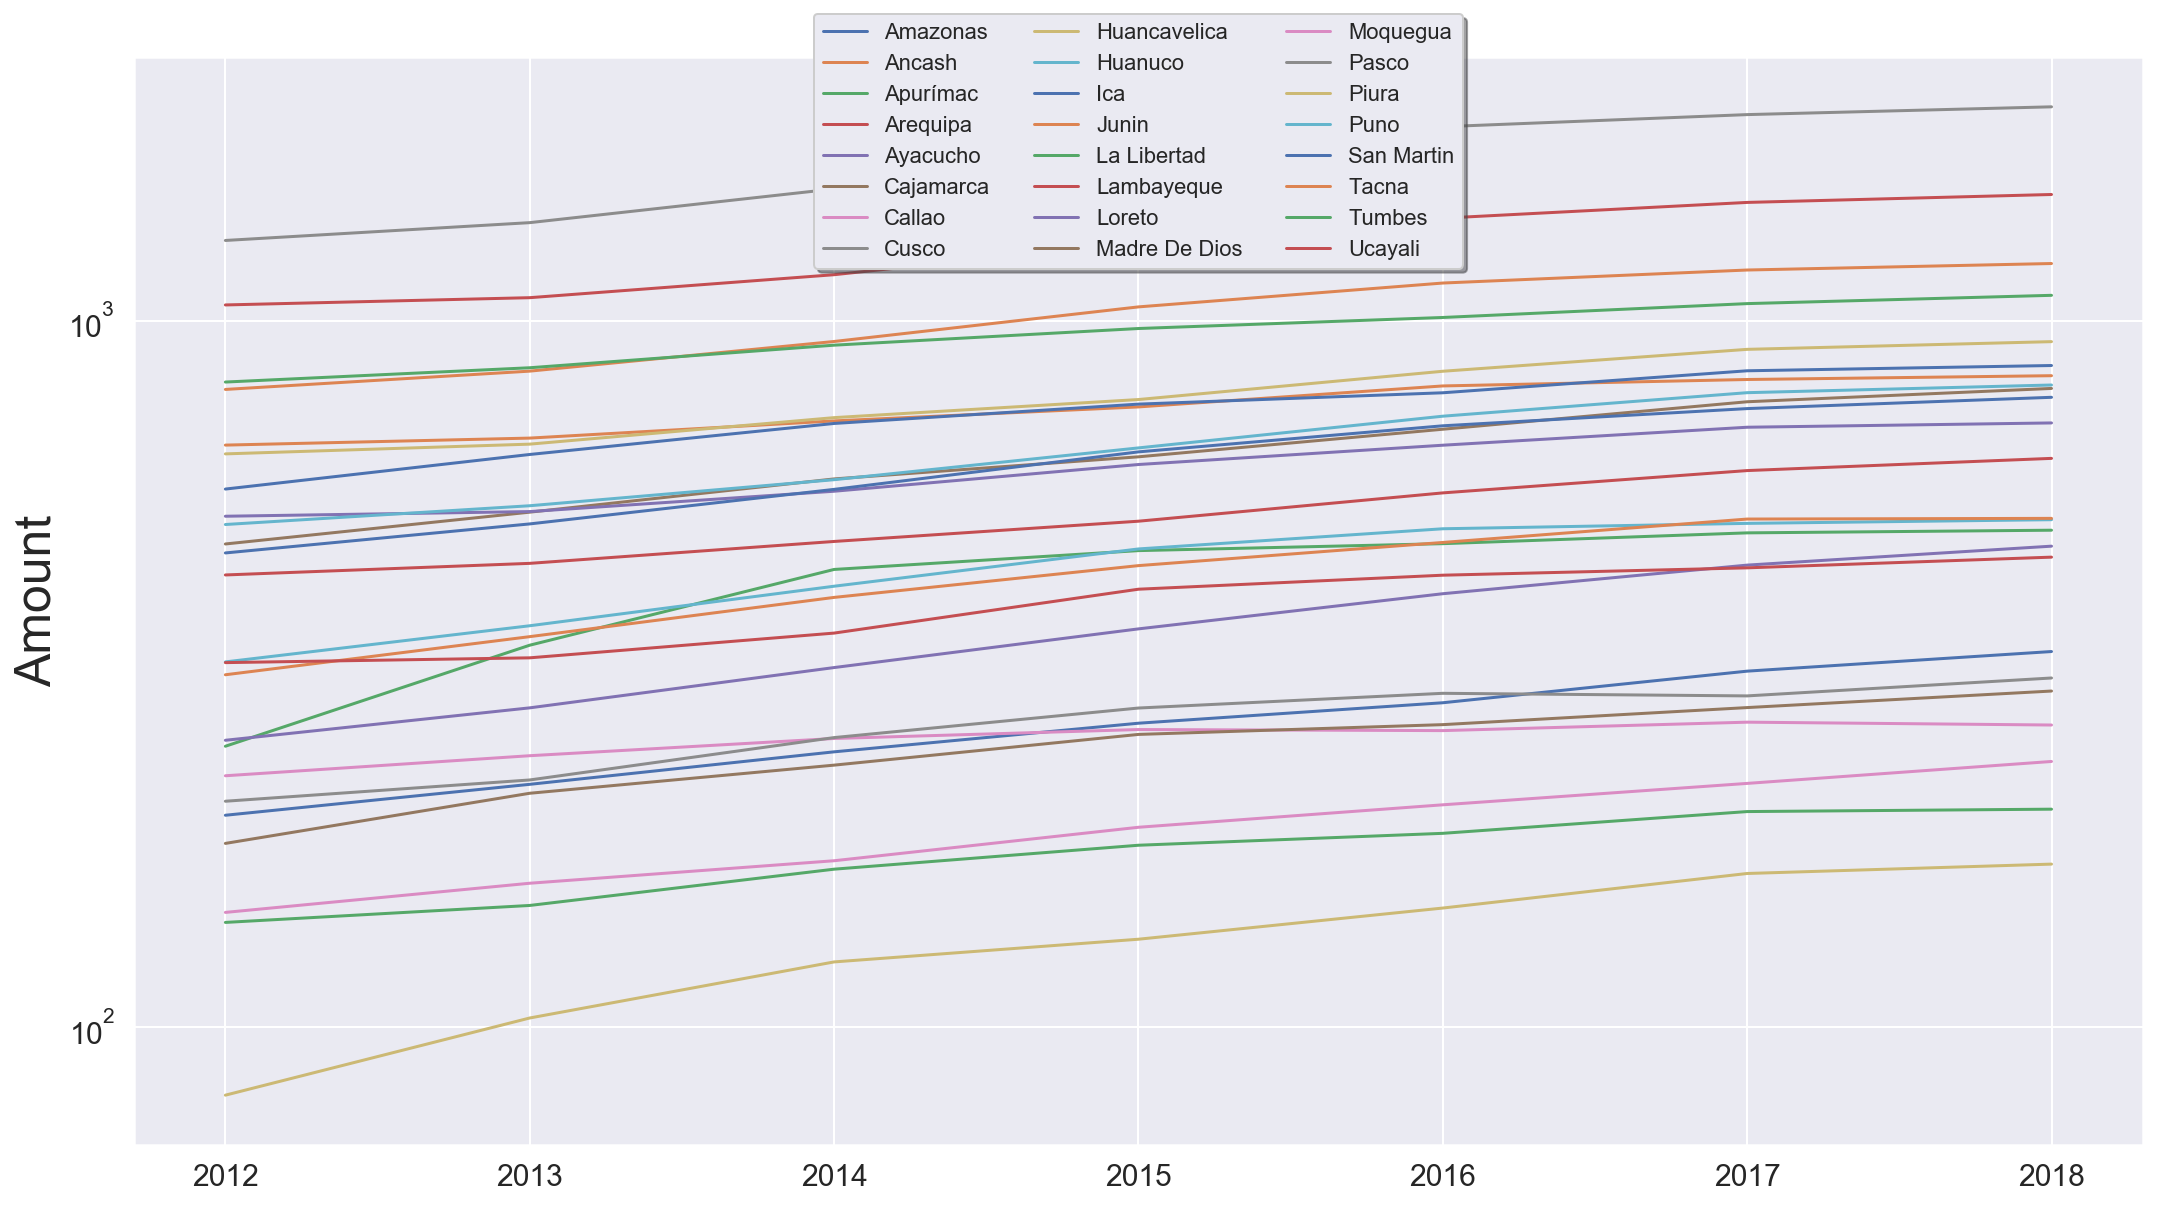

In [252]:
show_descriptive_data_byYear('rptaniomes_a.xls','rptaniomes')

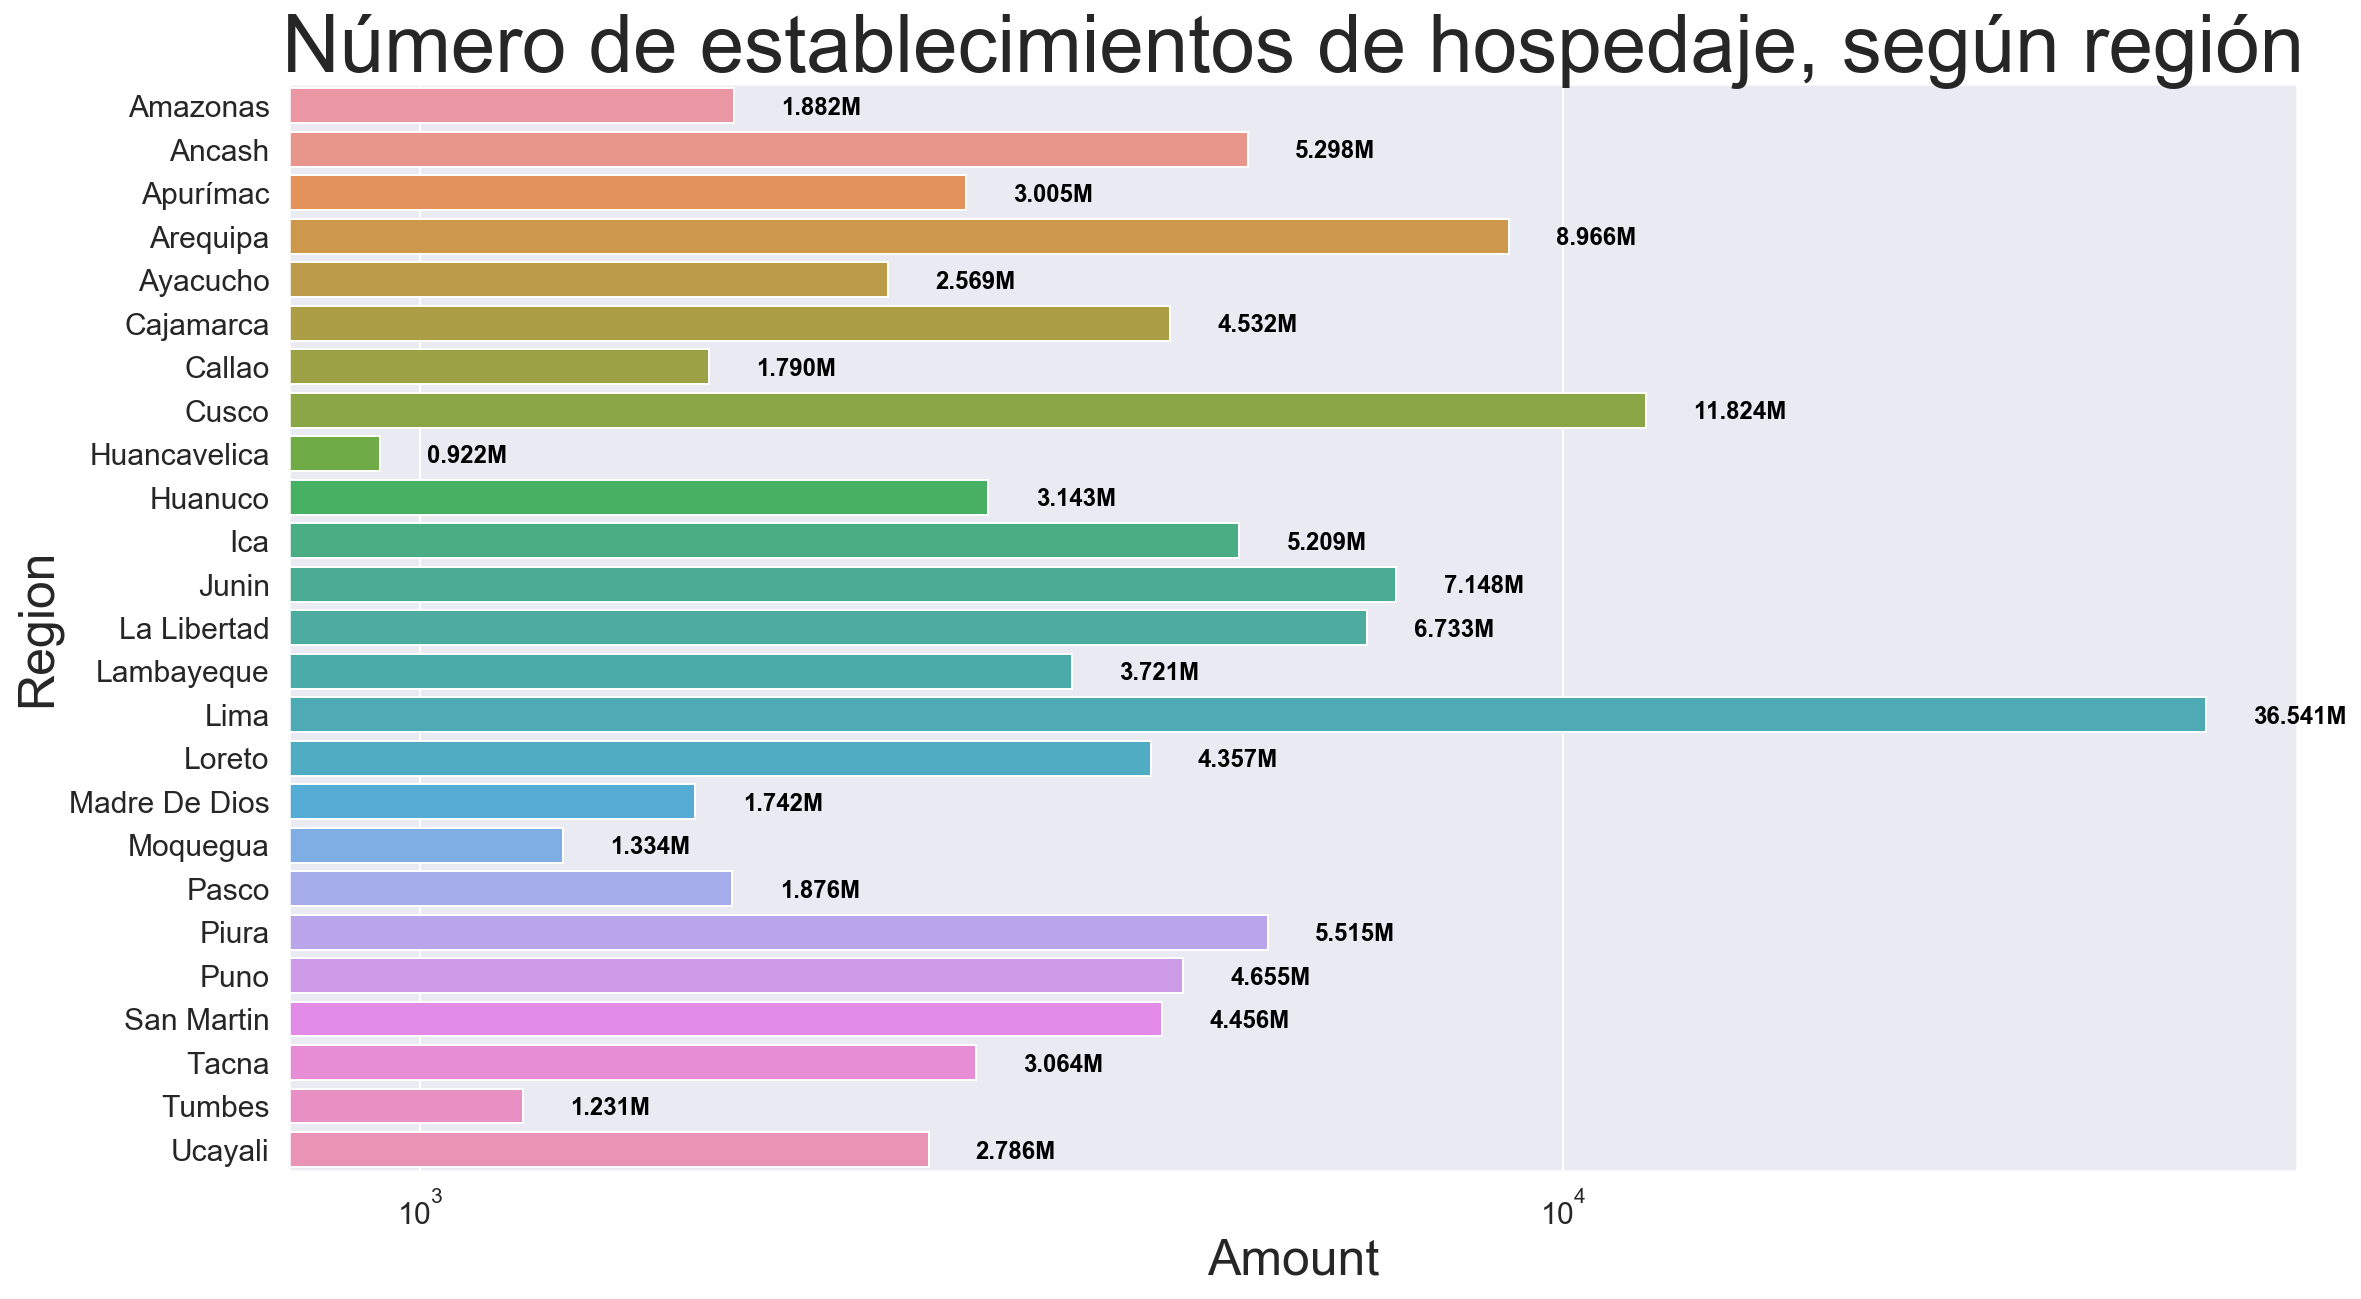

In [253]:
show_descriptive_data('rptaniomes_a.xls','rptaniomes',scale='log',
                      title='Número de establecimientos de hospedaje, según región')

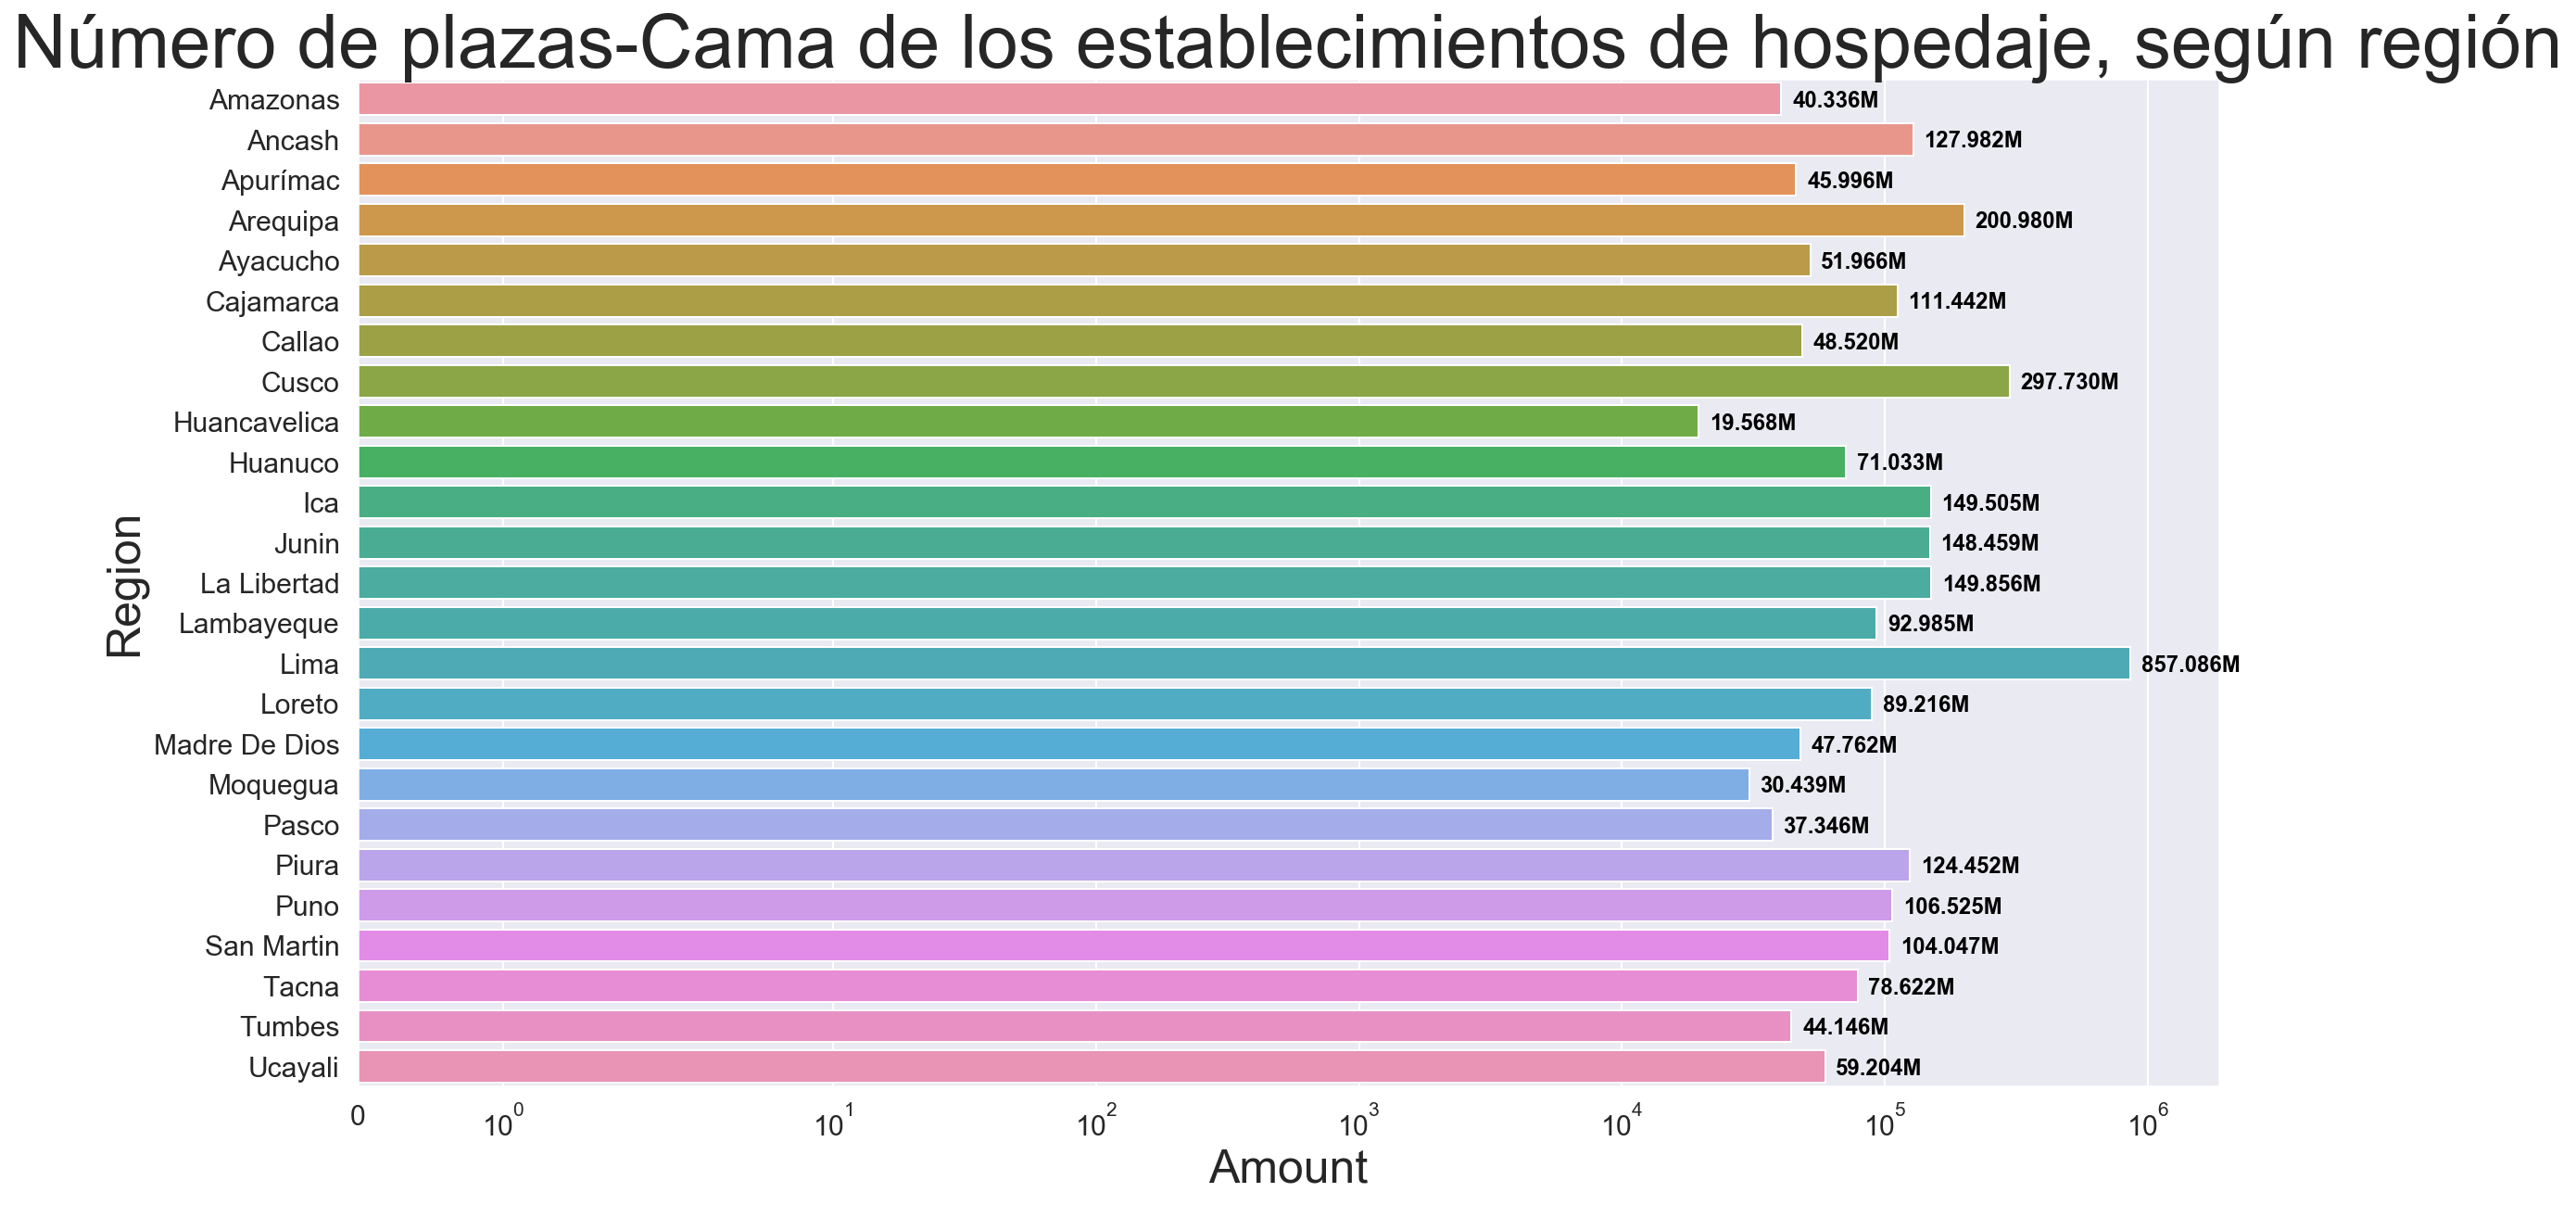

In [254]:
show_descriptive_data('rptaniomes_b.xls','rptaniomes',
                      title='Número de plazas-Cama de los establecimientos de hospedaje, según región')

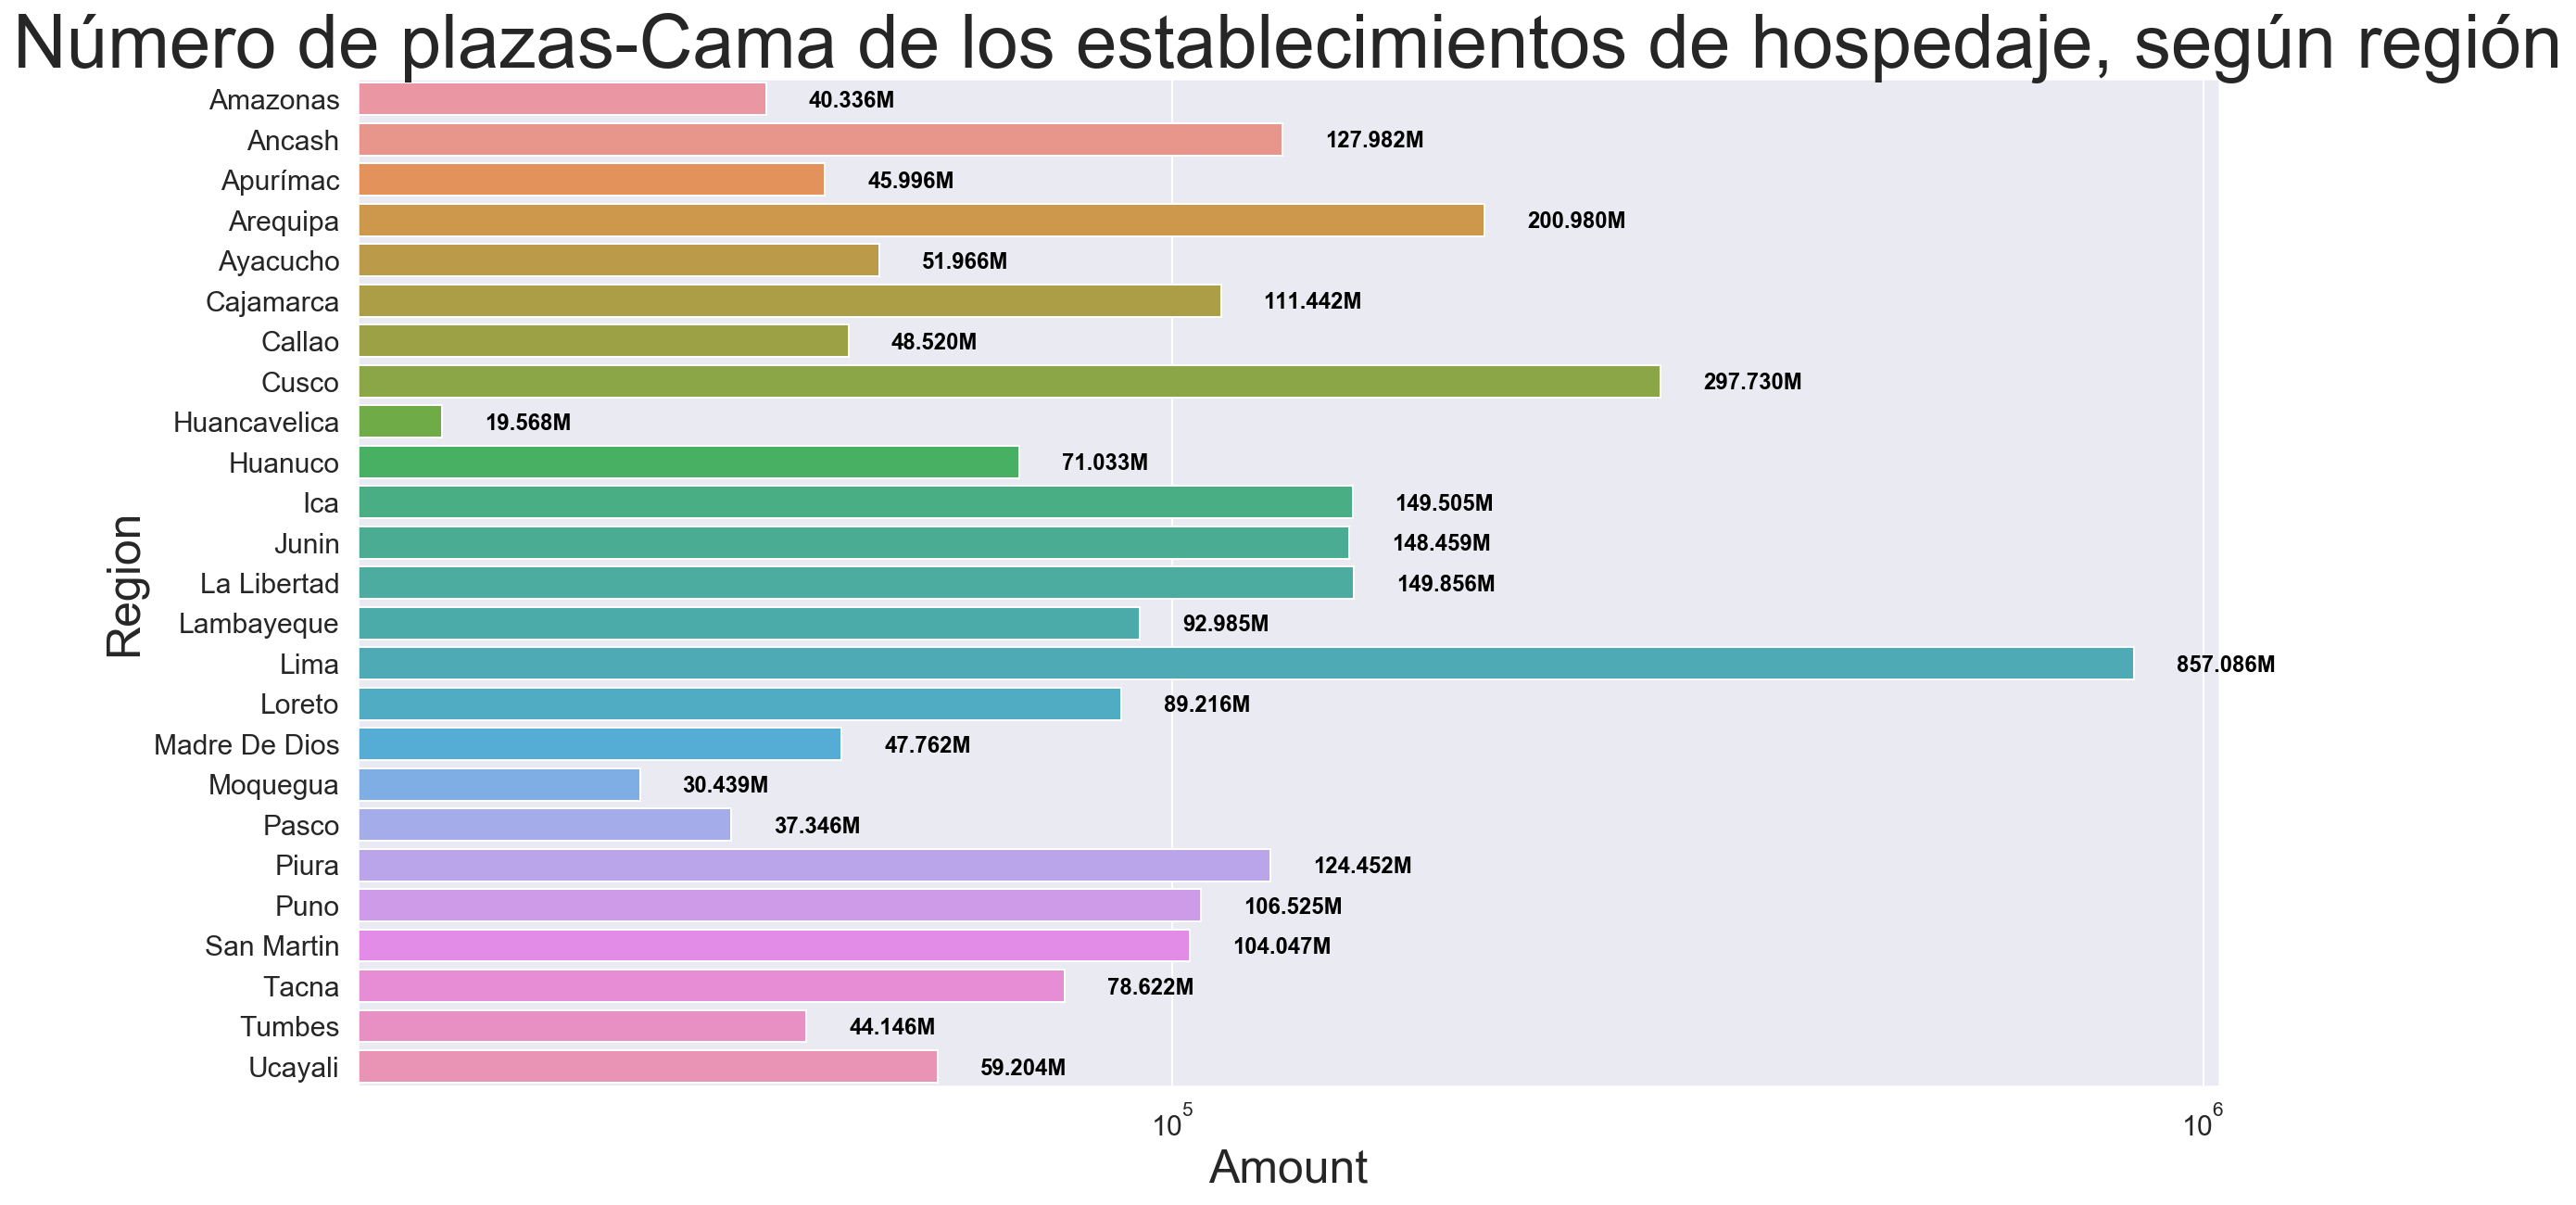

In [255]:
show_descriptive_data('rptaniomes_b.xls','rptaniomes',scale='log',
                      title='Número de plazas-Cama de los establecimientos de hospedaje, según región')

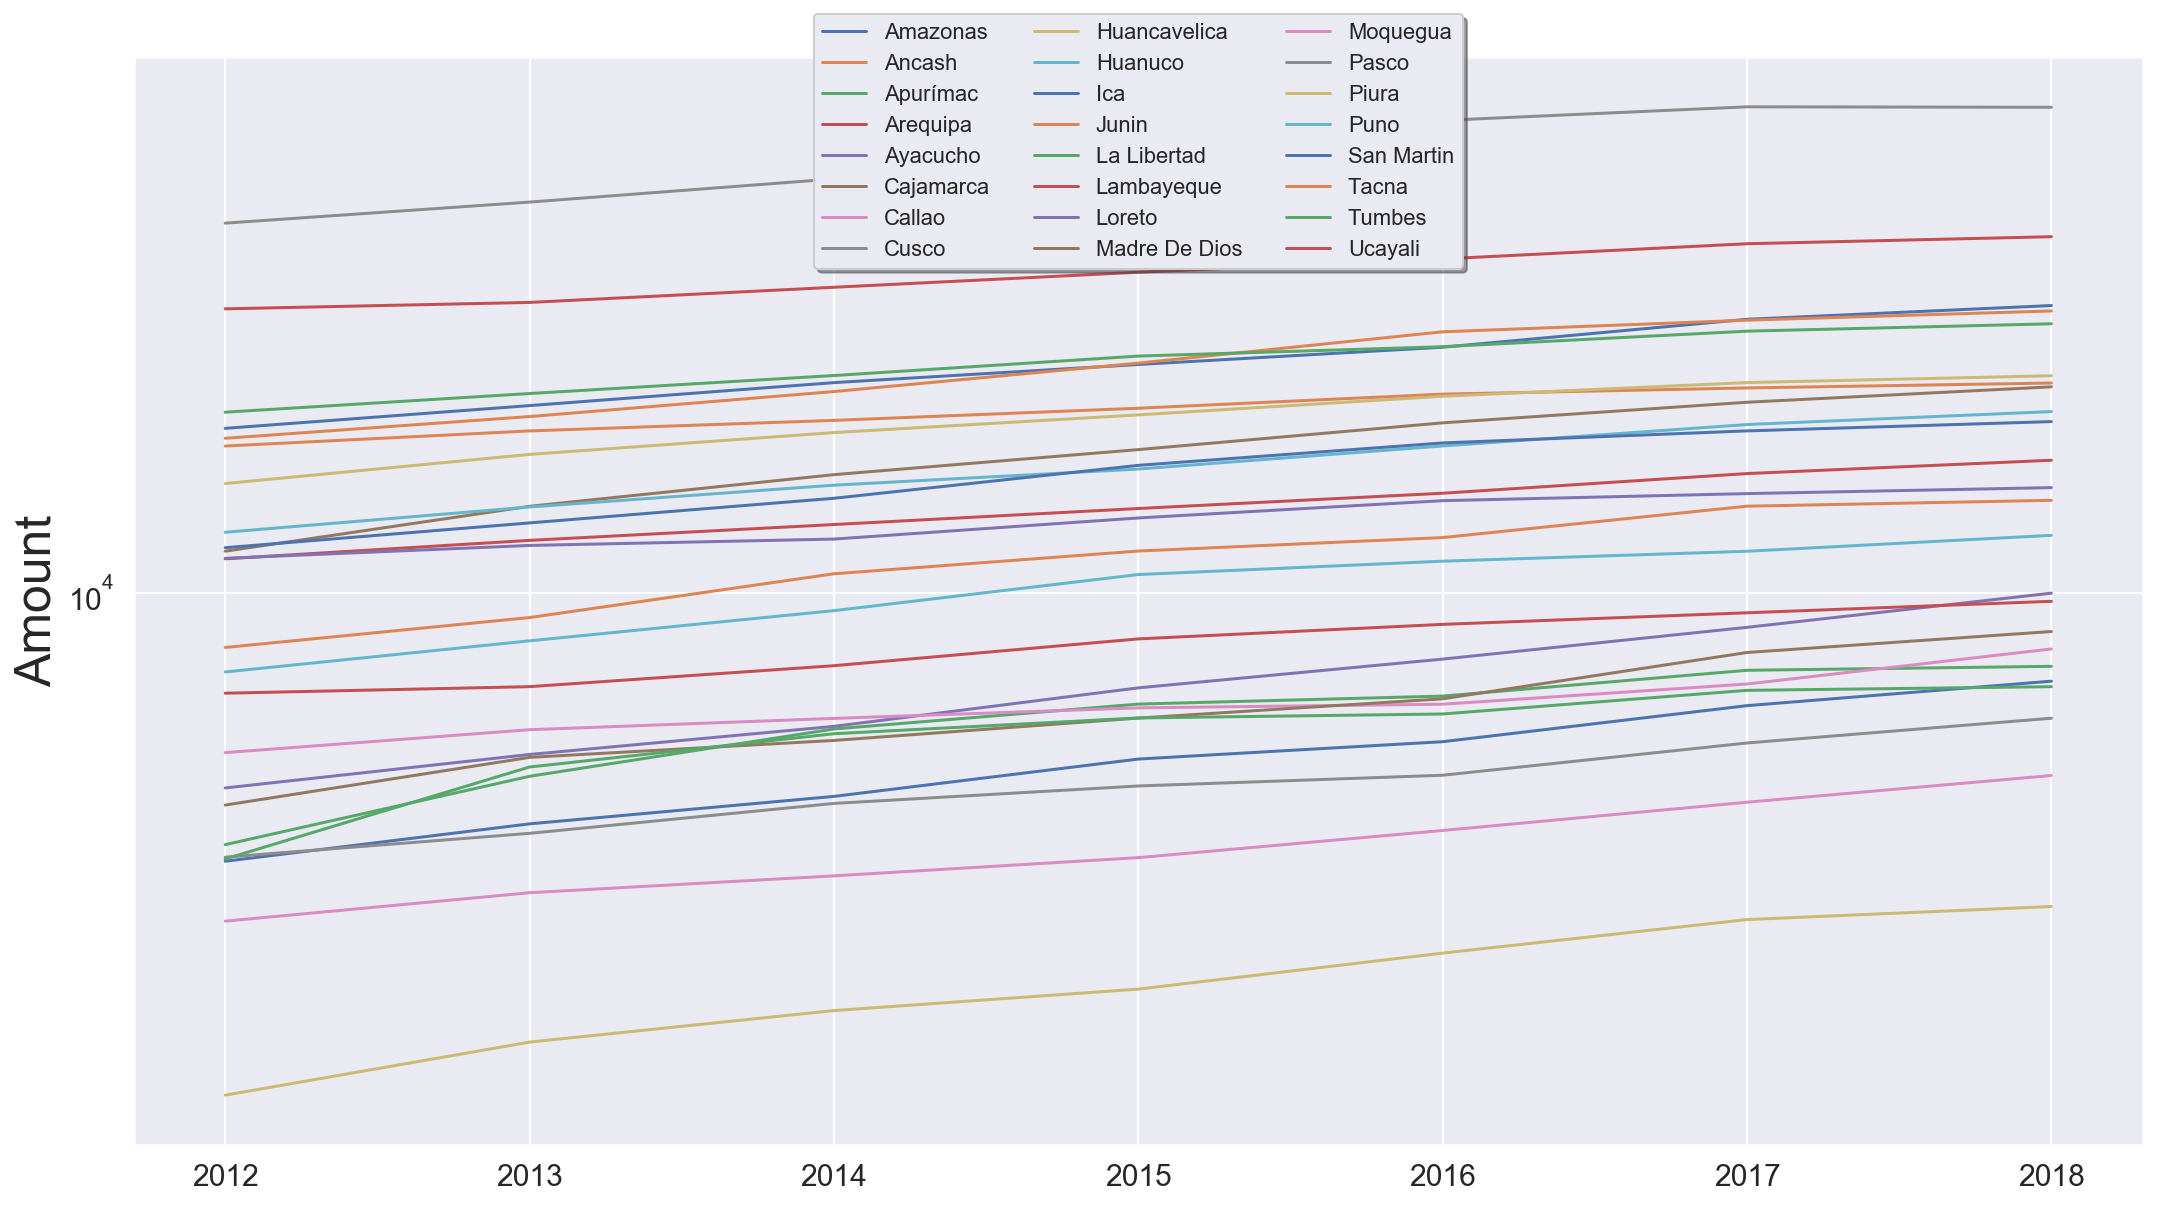

In [256]:
show_descriptive_data_byYear('rptaniomes_b.xls','rptaniomes')

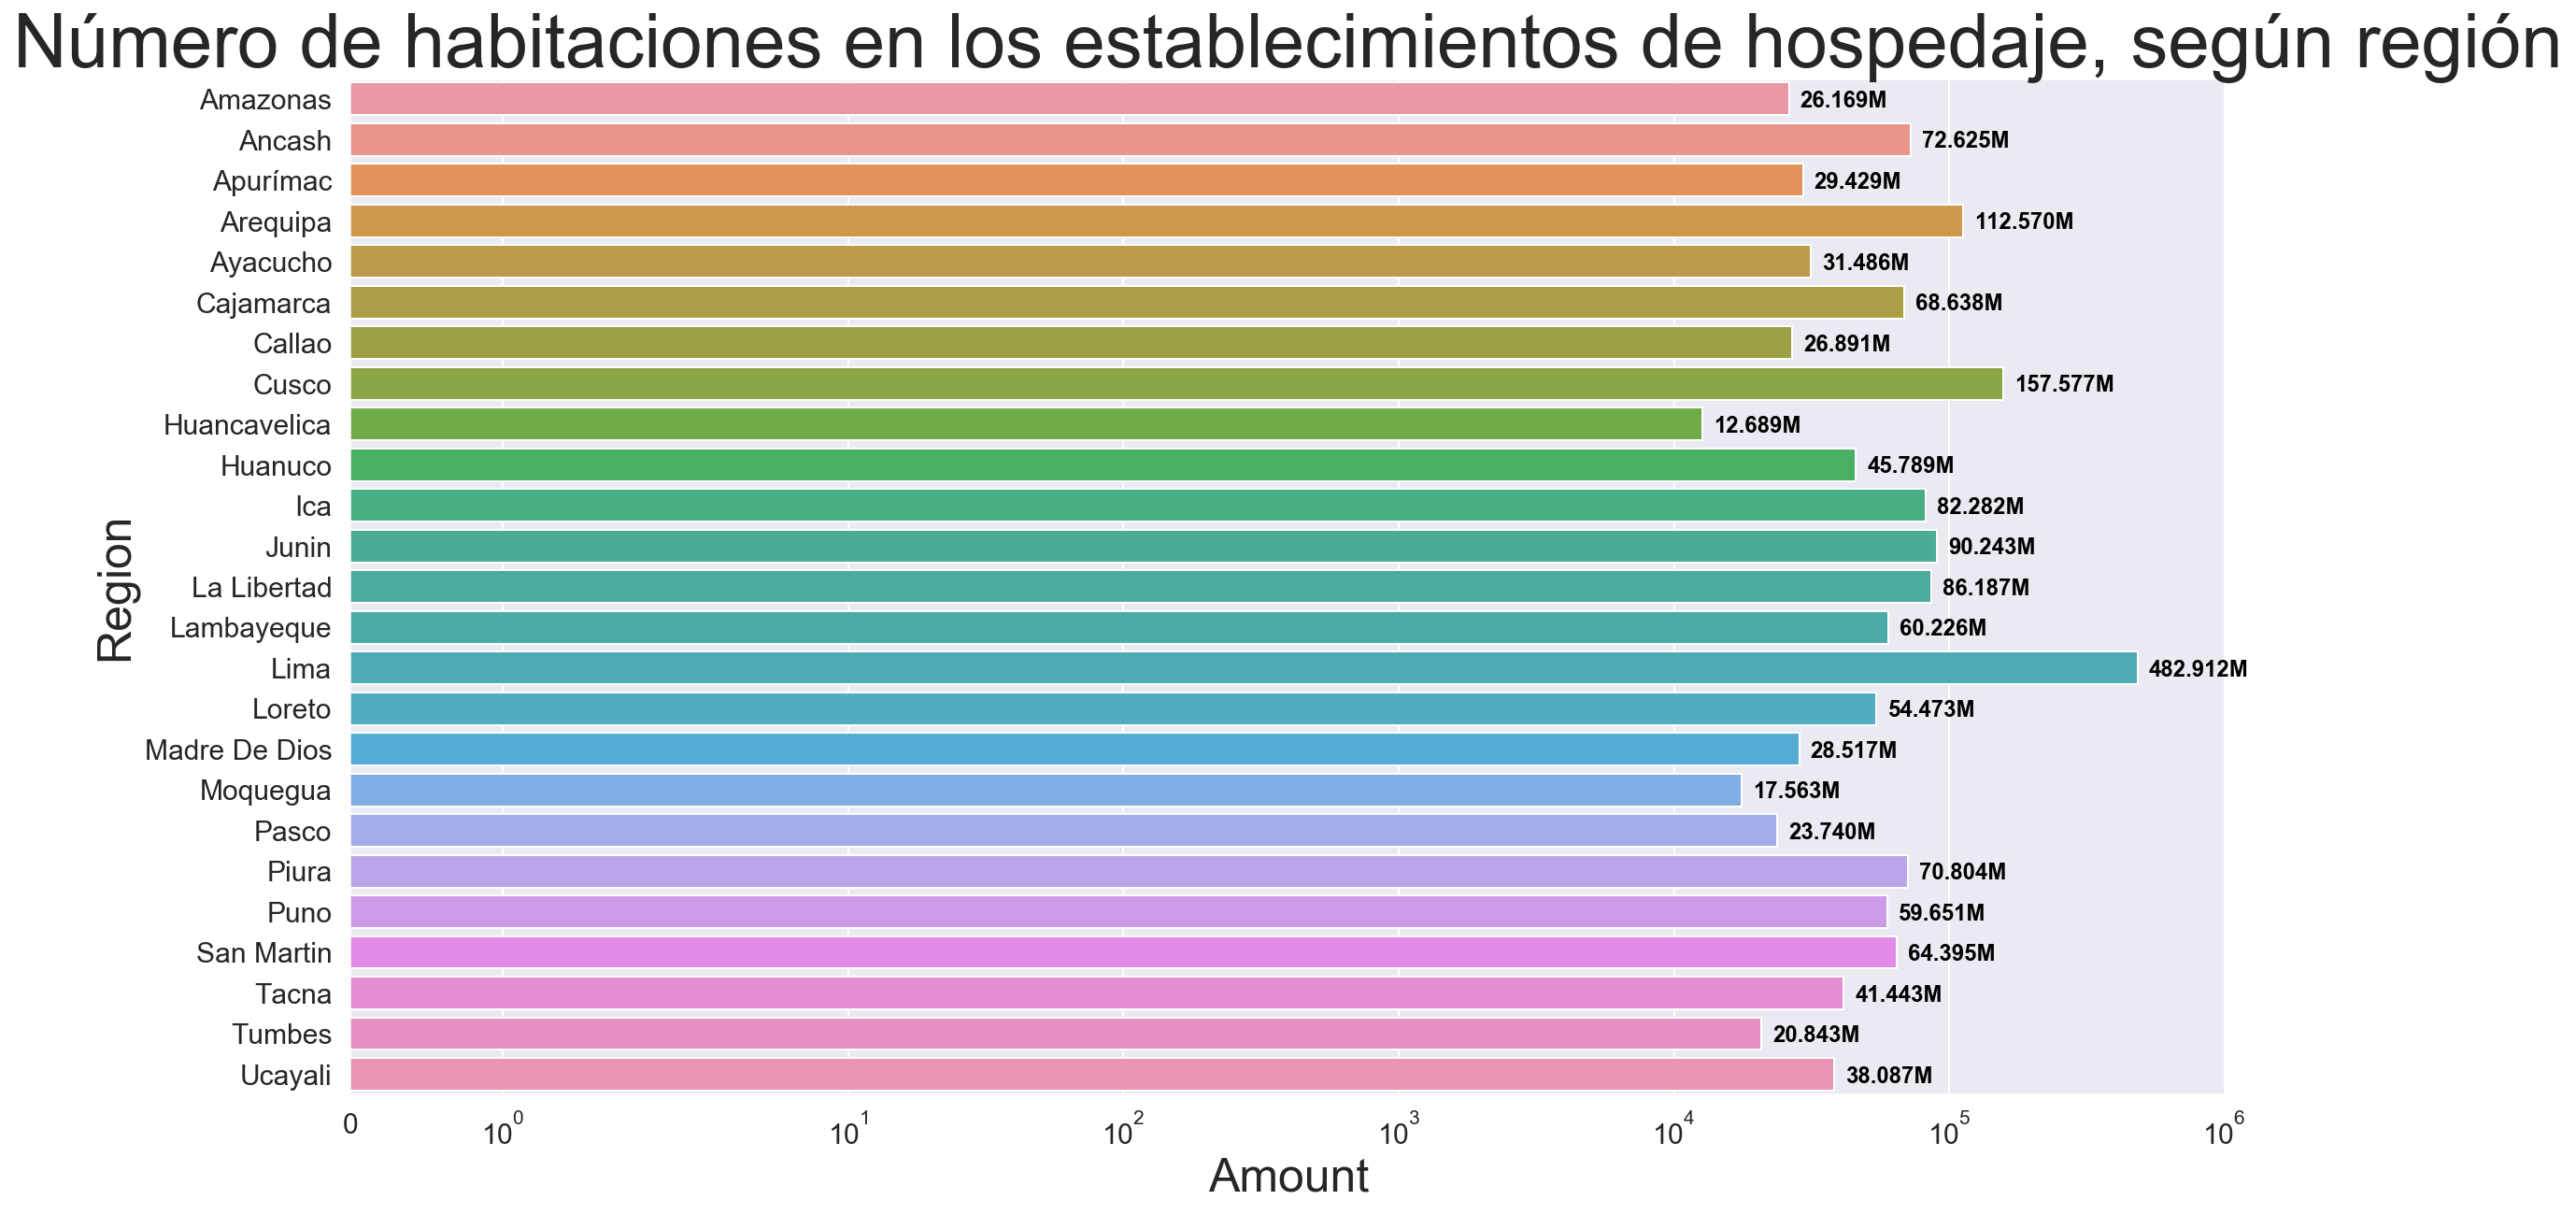

In [257]:
show_descriptive_data('rptaniomes_c.xls','rptaniomes',
                      title='Número de habitaciones en los establecimientos de hospedaje, según región')

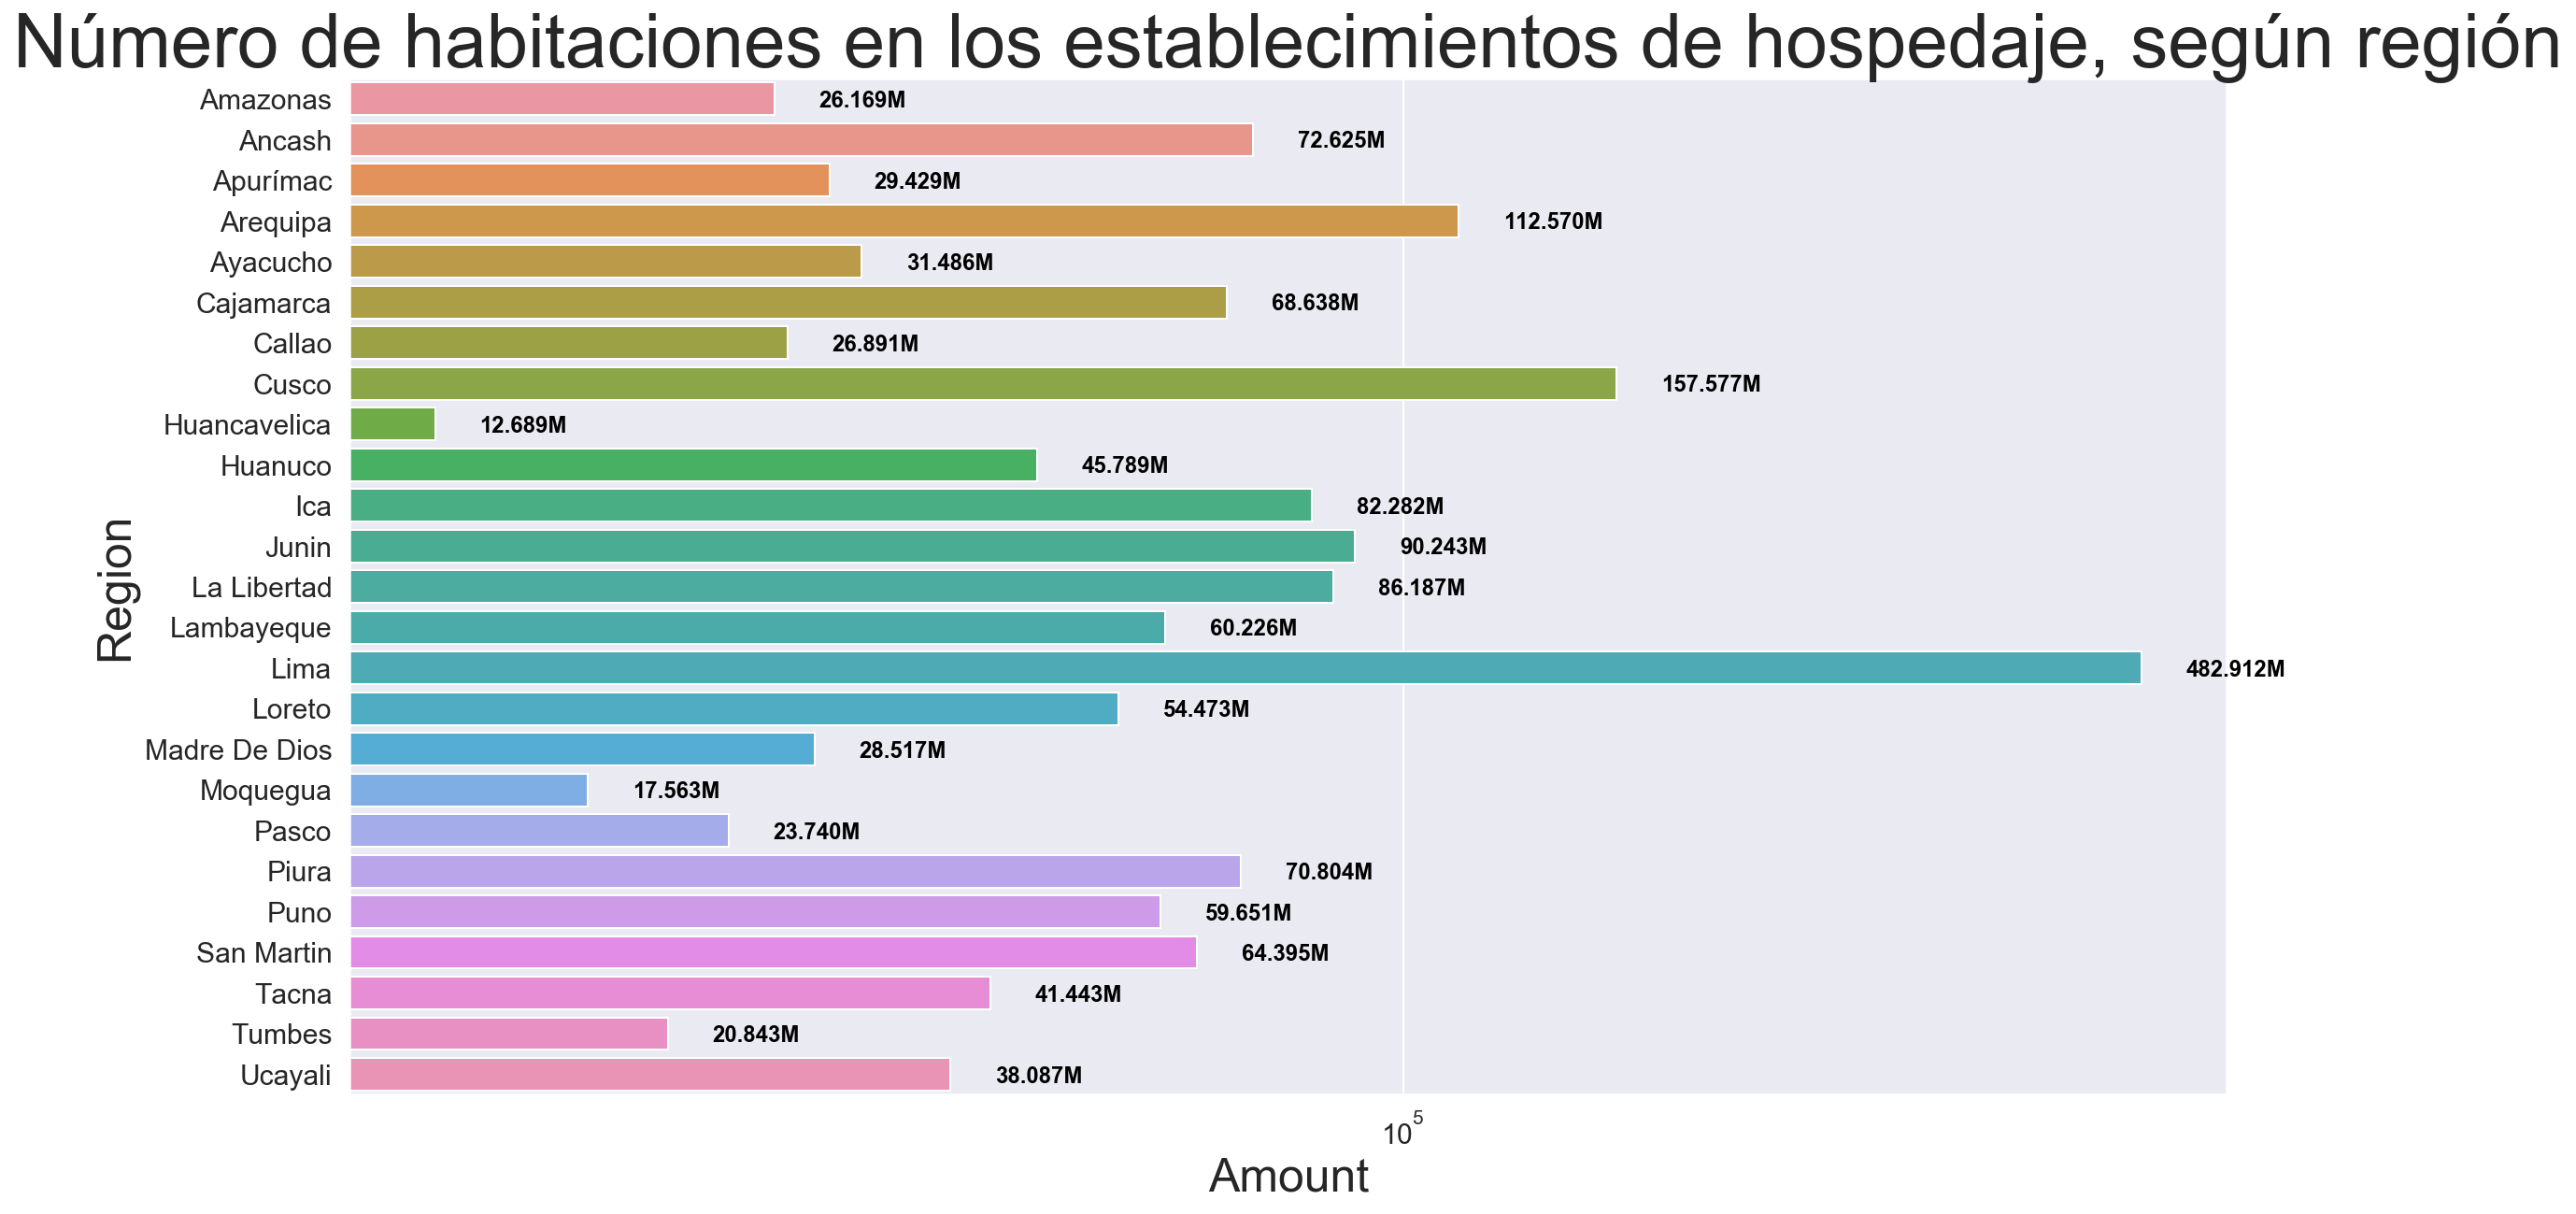

In [258]:
show_descriptive_data('rptaniomes_c.xls','rptaniomes',scale='log',
                      title='Número de habitaciones en los establecimientos de hospedaje, según región')

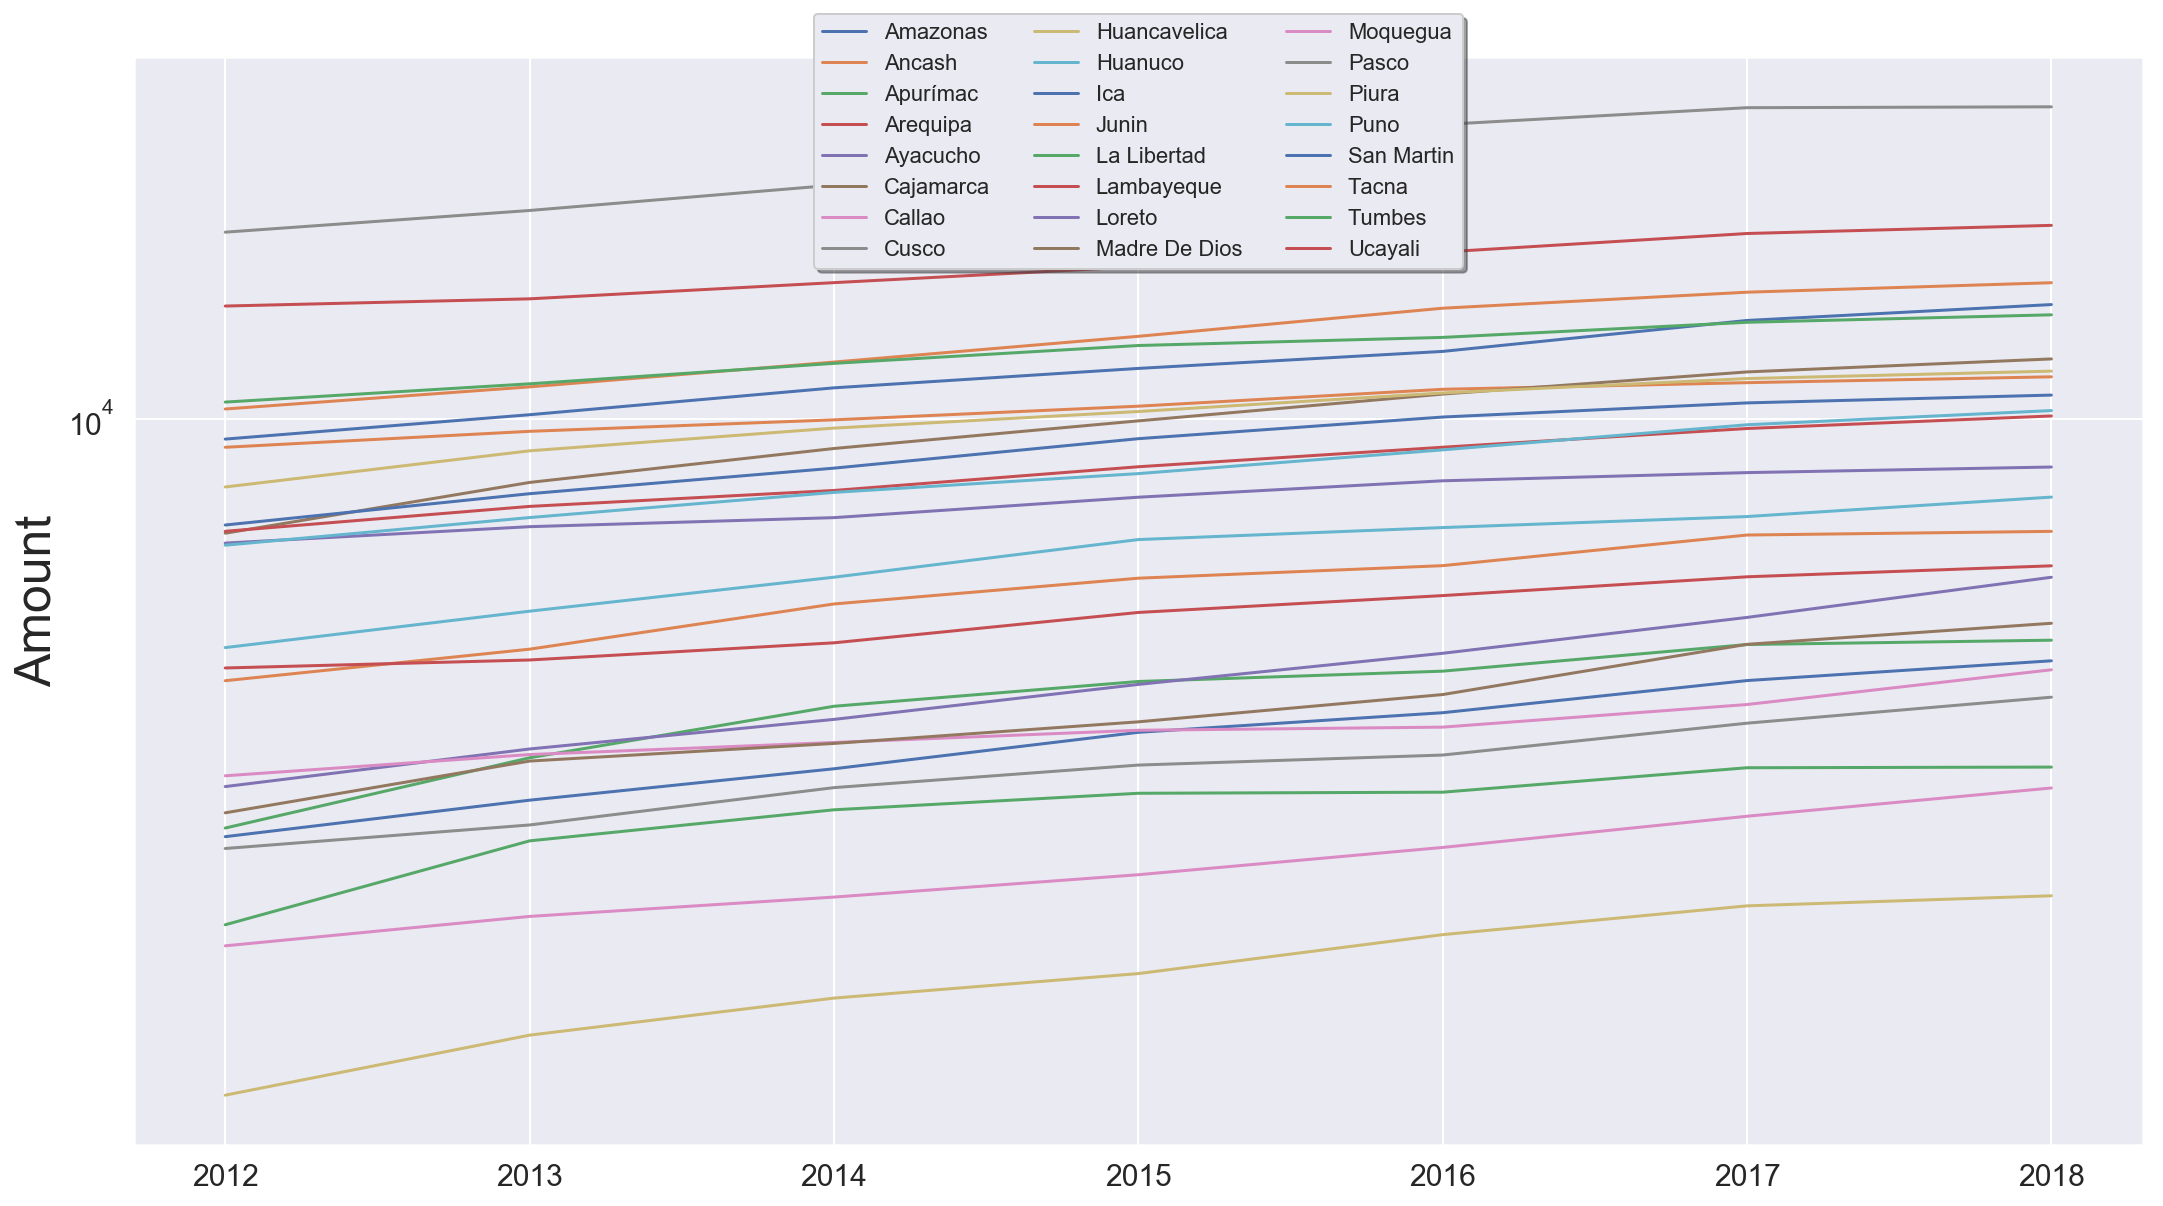

In [259]:
show_descriptive_data_byYear('rptaniomes_c.xls','rptaniomes')

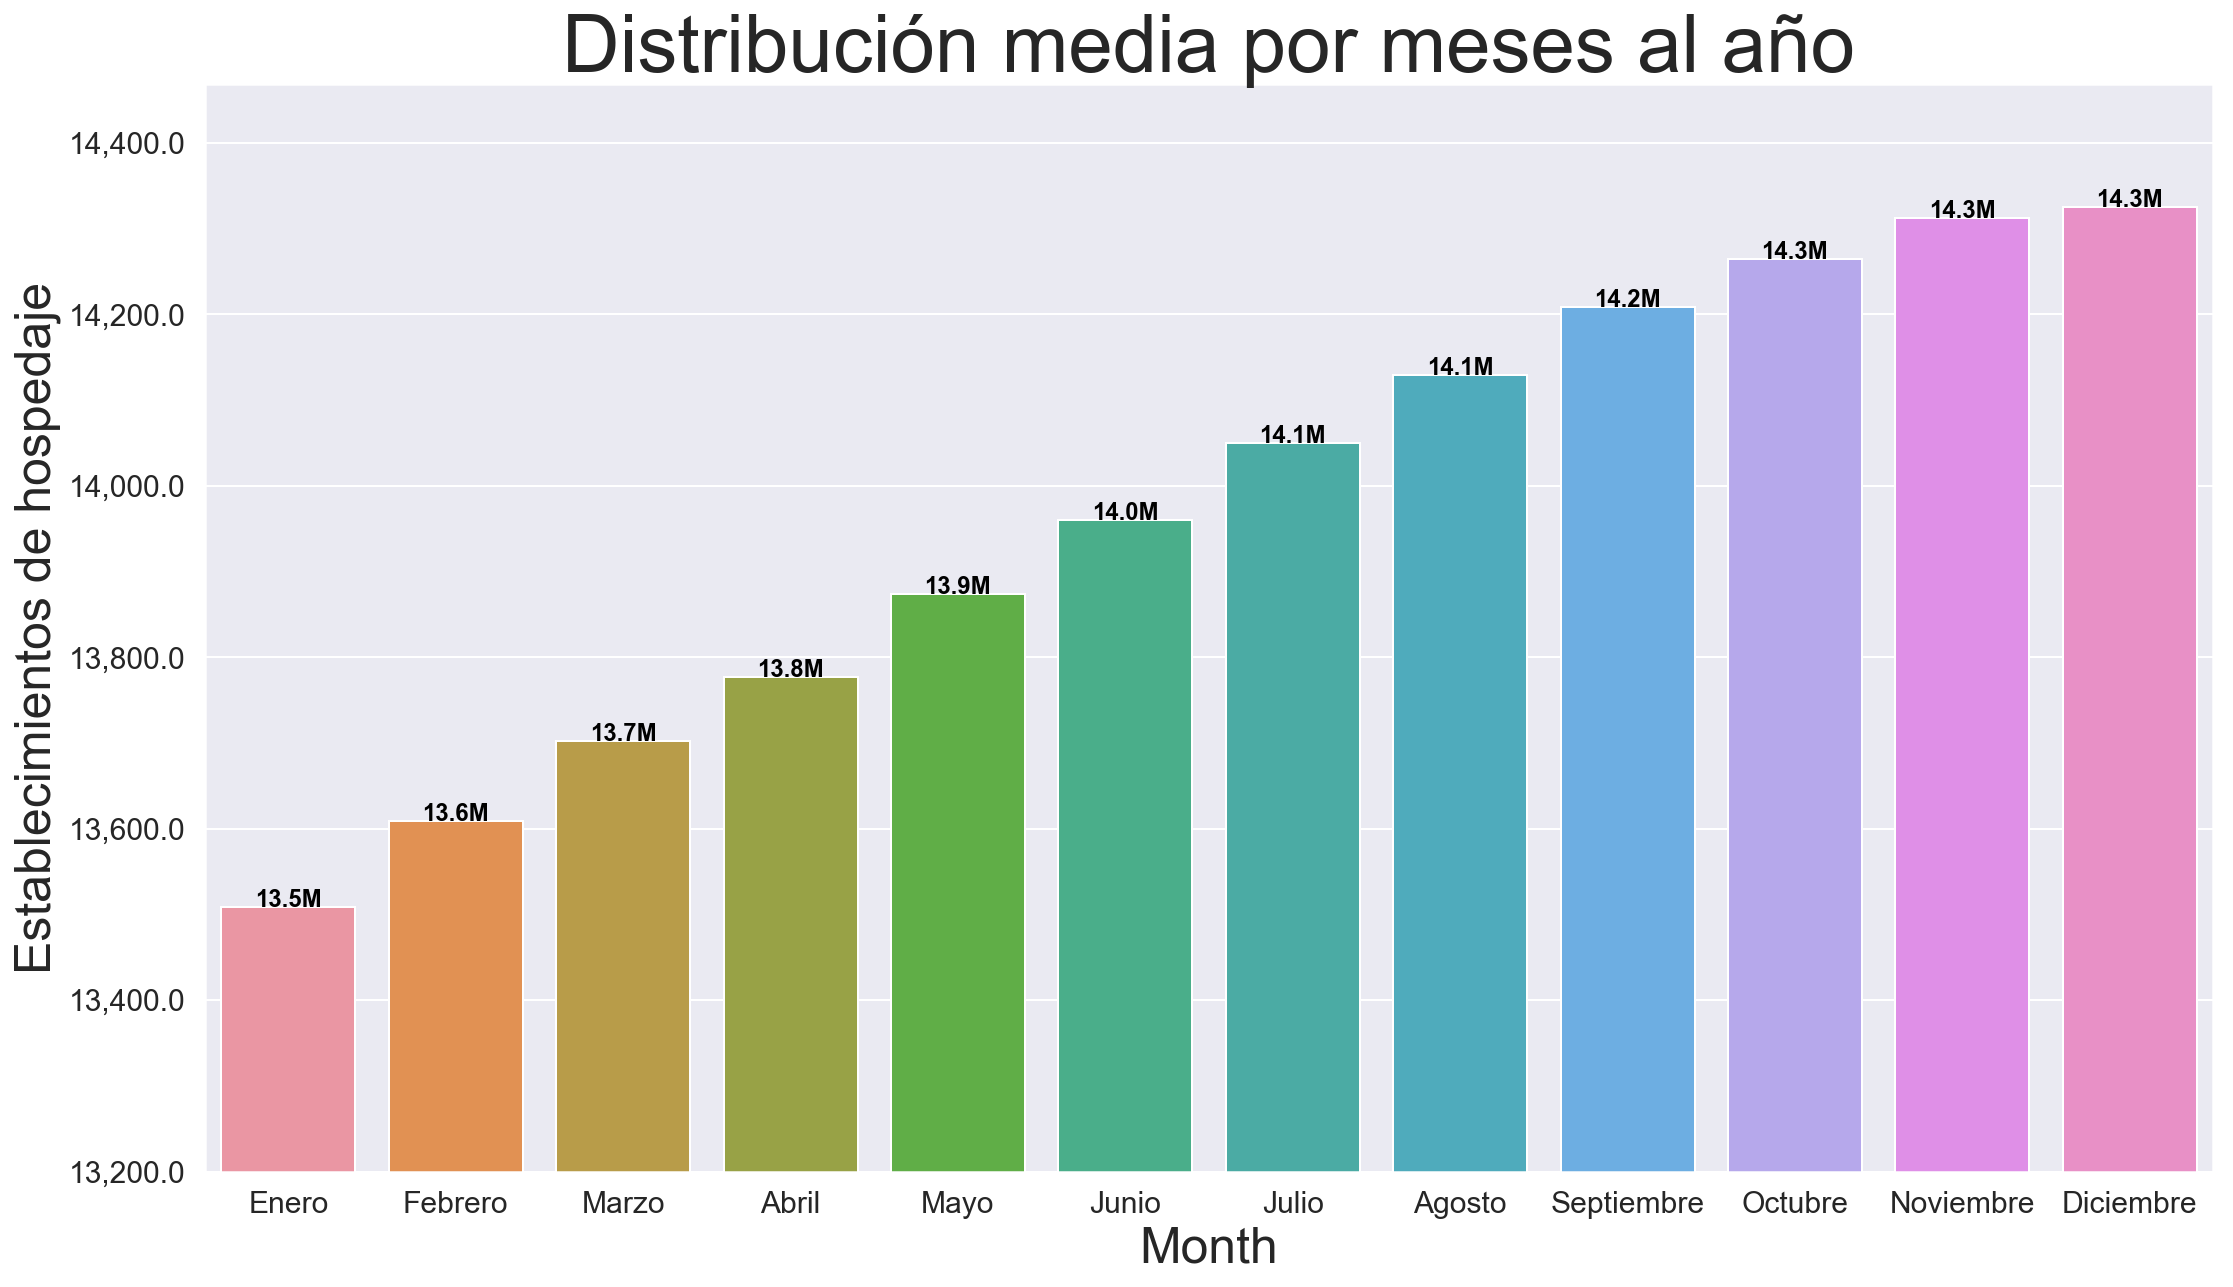

In [312]:
def show_descriptive_data_by_month(name_file,title ='Tourist'):
    df = pd.read_excel(name_file,sheet_name='rptaniomesp',nrows=12,
                           skiprows=4,index_col=0,)
    clean_dataframe(df)
    df = df.T
    col_name = 'Month'
    info = df.median().to_frame().reset_index()
    info.columns = [col_name,title]
    ax = sns.barplot(data=info,x=col_name,y=title)
    vals = info[title].values
    for i, v in enumerate(vals):
        ax.text(i-.2 , v , str('%.1fM'%(v/1000)), color='black', fontweight='bold')
    plt.ylim((vals.min()*.99,vals.max()*1.01))
    xx, locs = plt.yticks()
    ll = ['{:,}'.format(a) for a in xx]
    plt.yticks(xx[:-1], ll[:-1])
    plt.title('Distribución media por meses al año')
    plt.show();
    
show_descriptive_data_by_month('rptaniomesp_a.xls','Establecimientos de hospedaje')

In [301]:
dic = dict(Enero=1,Febrero=2,Marzo=3,Abril=4,Mayo=5,Junio=6,Julio=7,
           Agosto=8,Septiembre=9,Octubre=10,Noviembre=11,Diciembre=12)

def predict_plot(name_file,title):
    df = pd.read_excel(name_file,sheet_name='rptaniomesp',nrows=12,
                           skiprows=4,index_col=0,)
    clean_dataframe(df)
    df = pd.melt(df.reset_index(), 
                id_vars='index', 
                value_vars=list(df.columns[1:]), # list of days of the week
                var_name='Year', 
                value_name='Sum of Tourist')
    df['Date'] = df['index'].map(dic)
    df.Date = df.apply(lambda row: pd.datetime(int(row['Year']), row['Date'],1), axis=1)
    df.set_index('Date',inplace=True)
    mod = sm.tsa.statespace.SARIMAX(df['Sum of Tourist'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    pred = results.get_prediction(start=pd.to_datetime('2016-12-01'),end=pd.to_datetime('2019-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = df['2016':'2017'].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Year')
    ax.set_ylabel(title)
    plt.title('Predicción de los próximos años')
    plt.legend()
    plt.show()

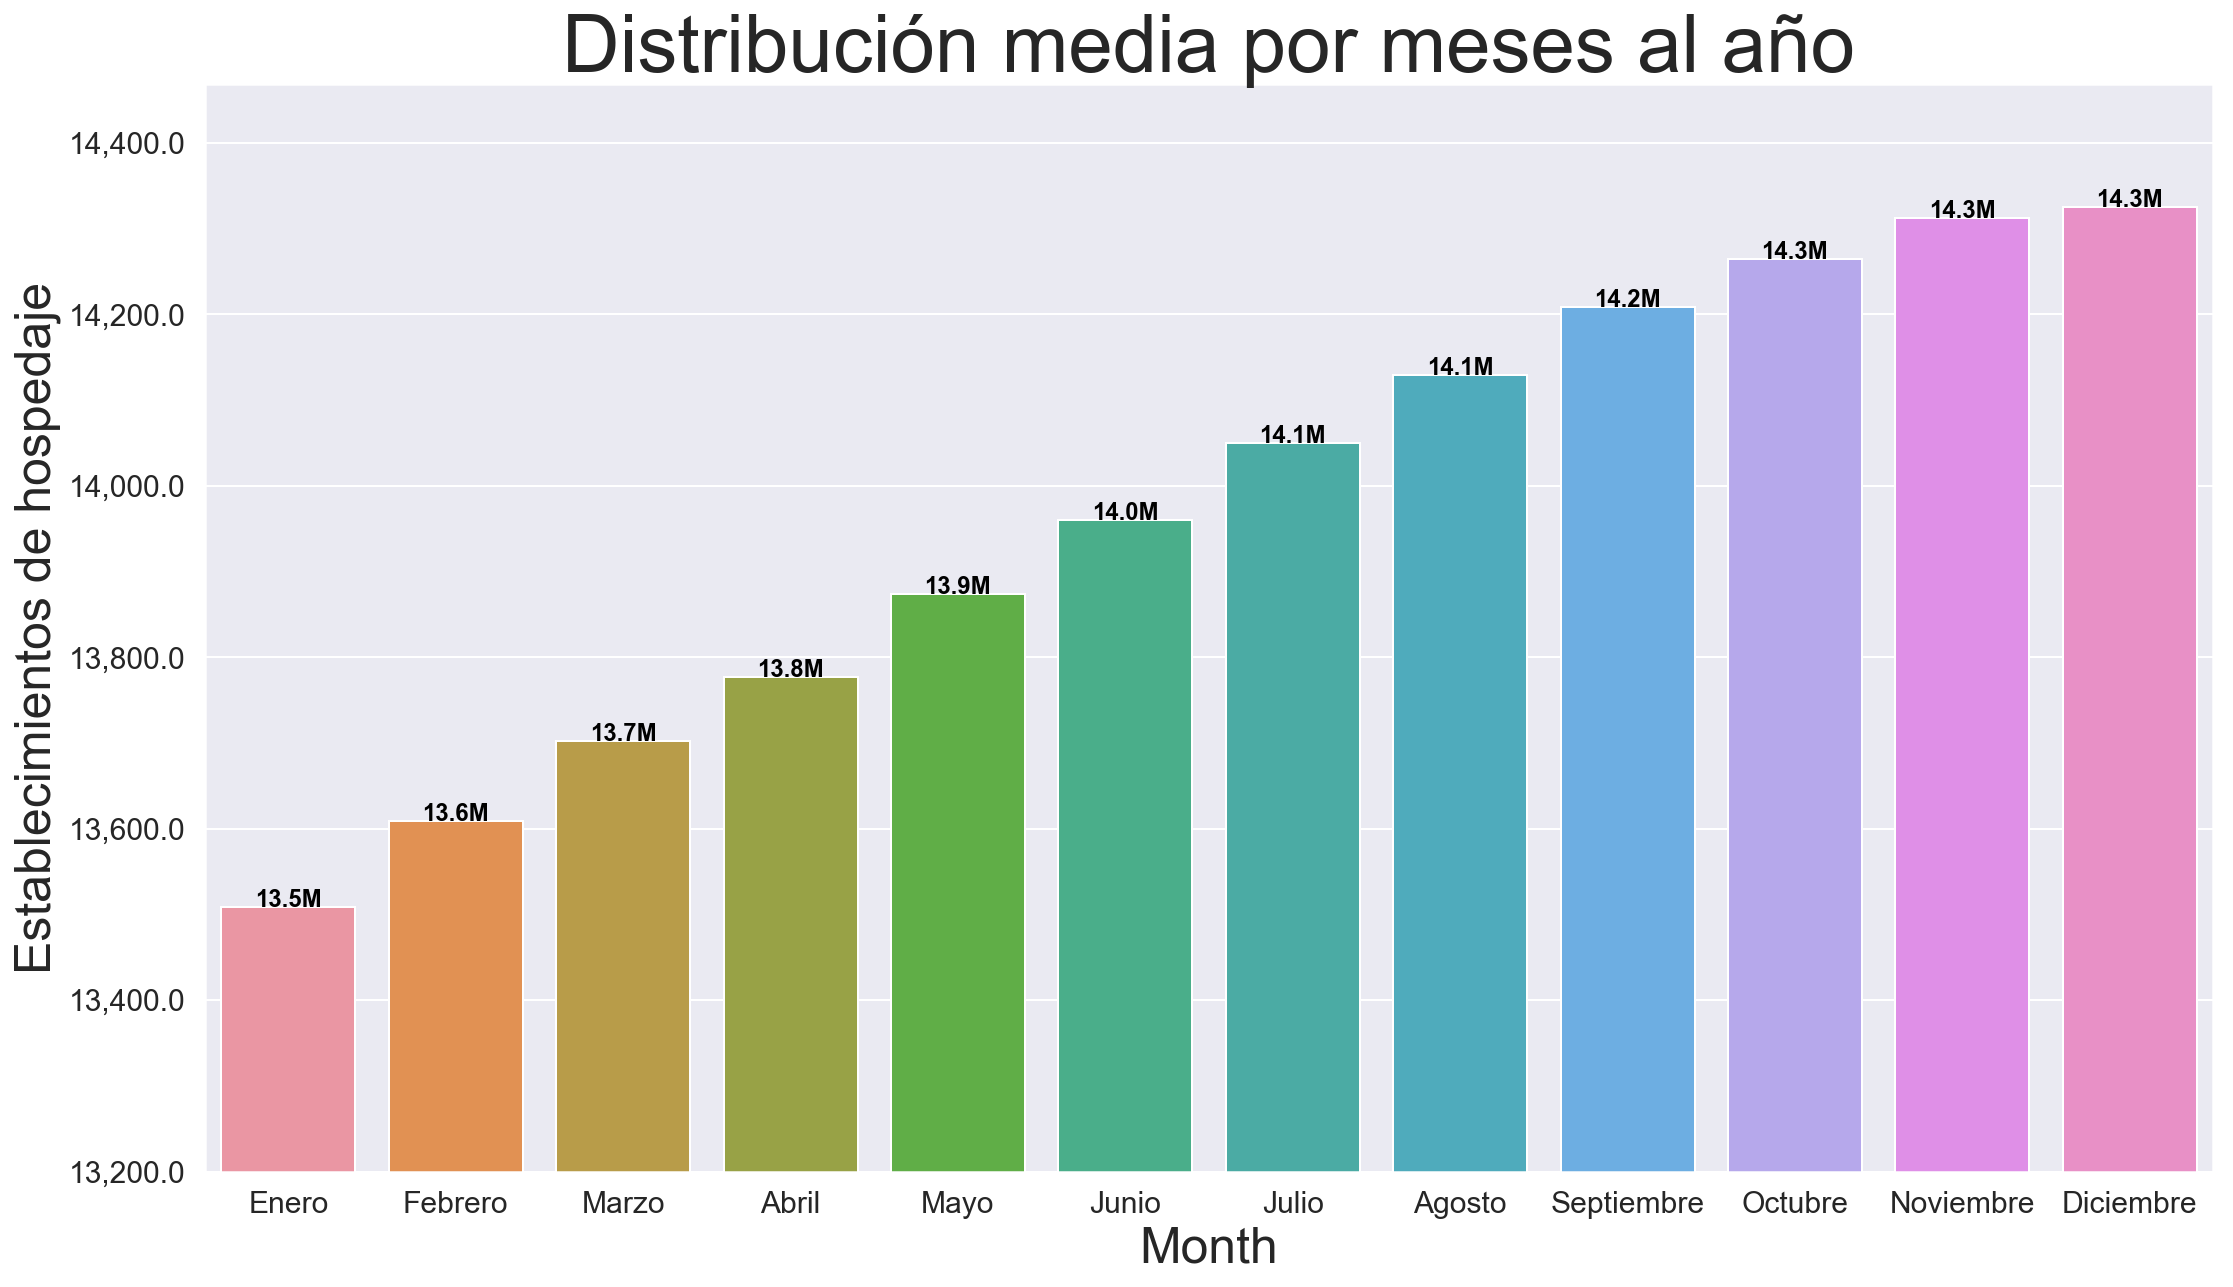

In [313]:
show_descriptive_data_by_month('rptaniomesp_a.xls','Establecimientos de hospedaje')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7883      0.111      7.097      0.000       0.571       1.006
ma.L1         -0.5396      0.172     -3.139      0.002      -0.876      -0.203
ar.S.L12      -0.5337      0.039    -13.554      0.000      -0.611      -0.456
sigma2      4004.4188    201.070     19.916      0.000    3610.330    4398.508


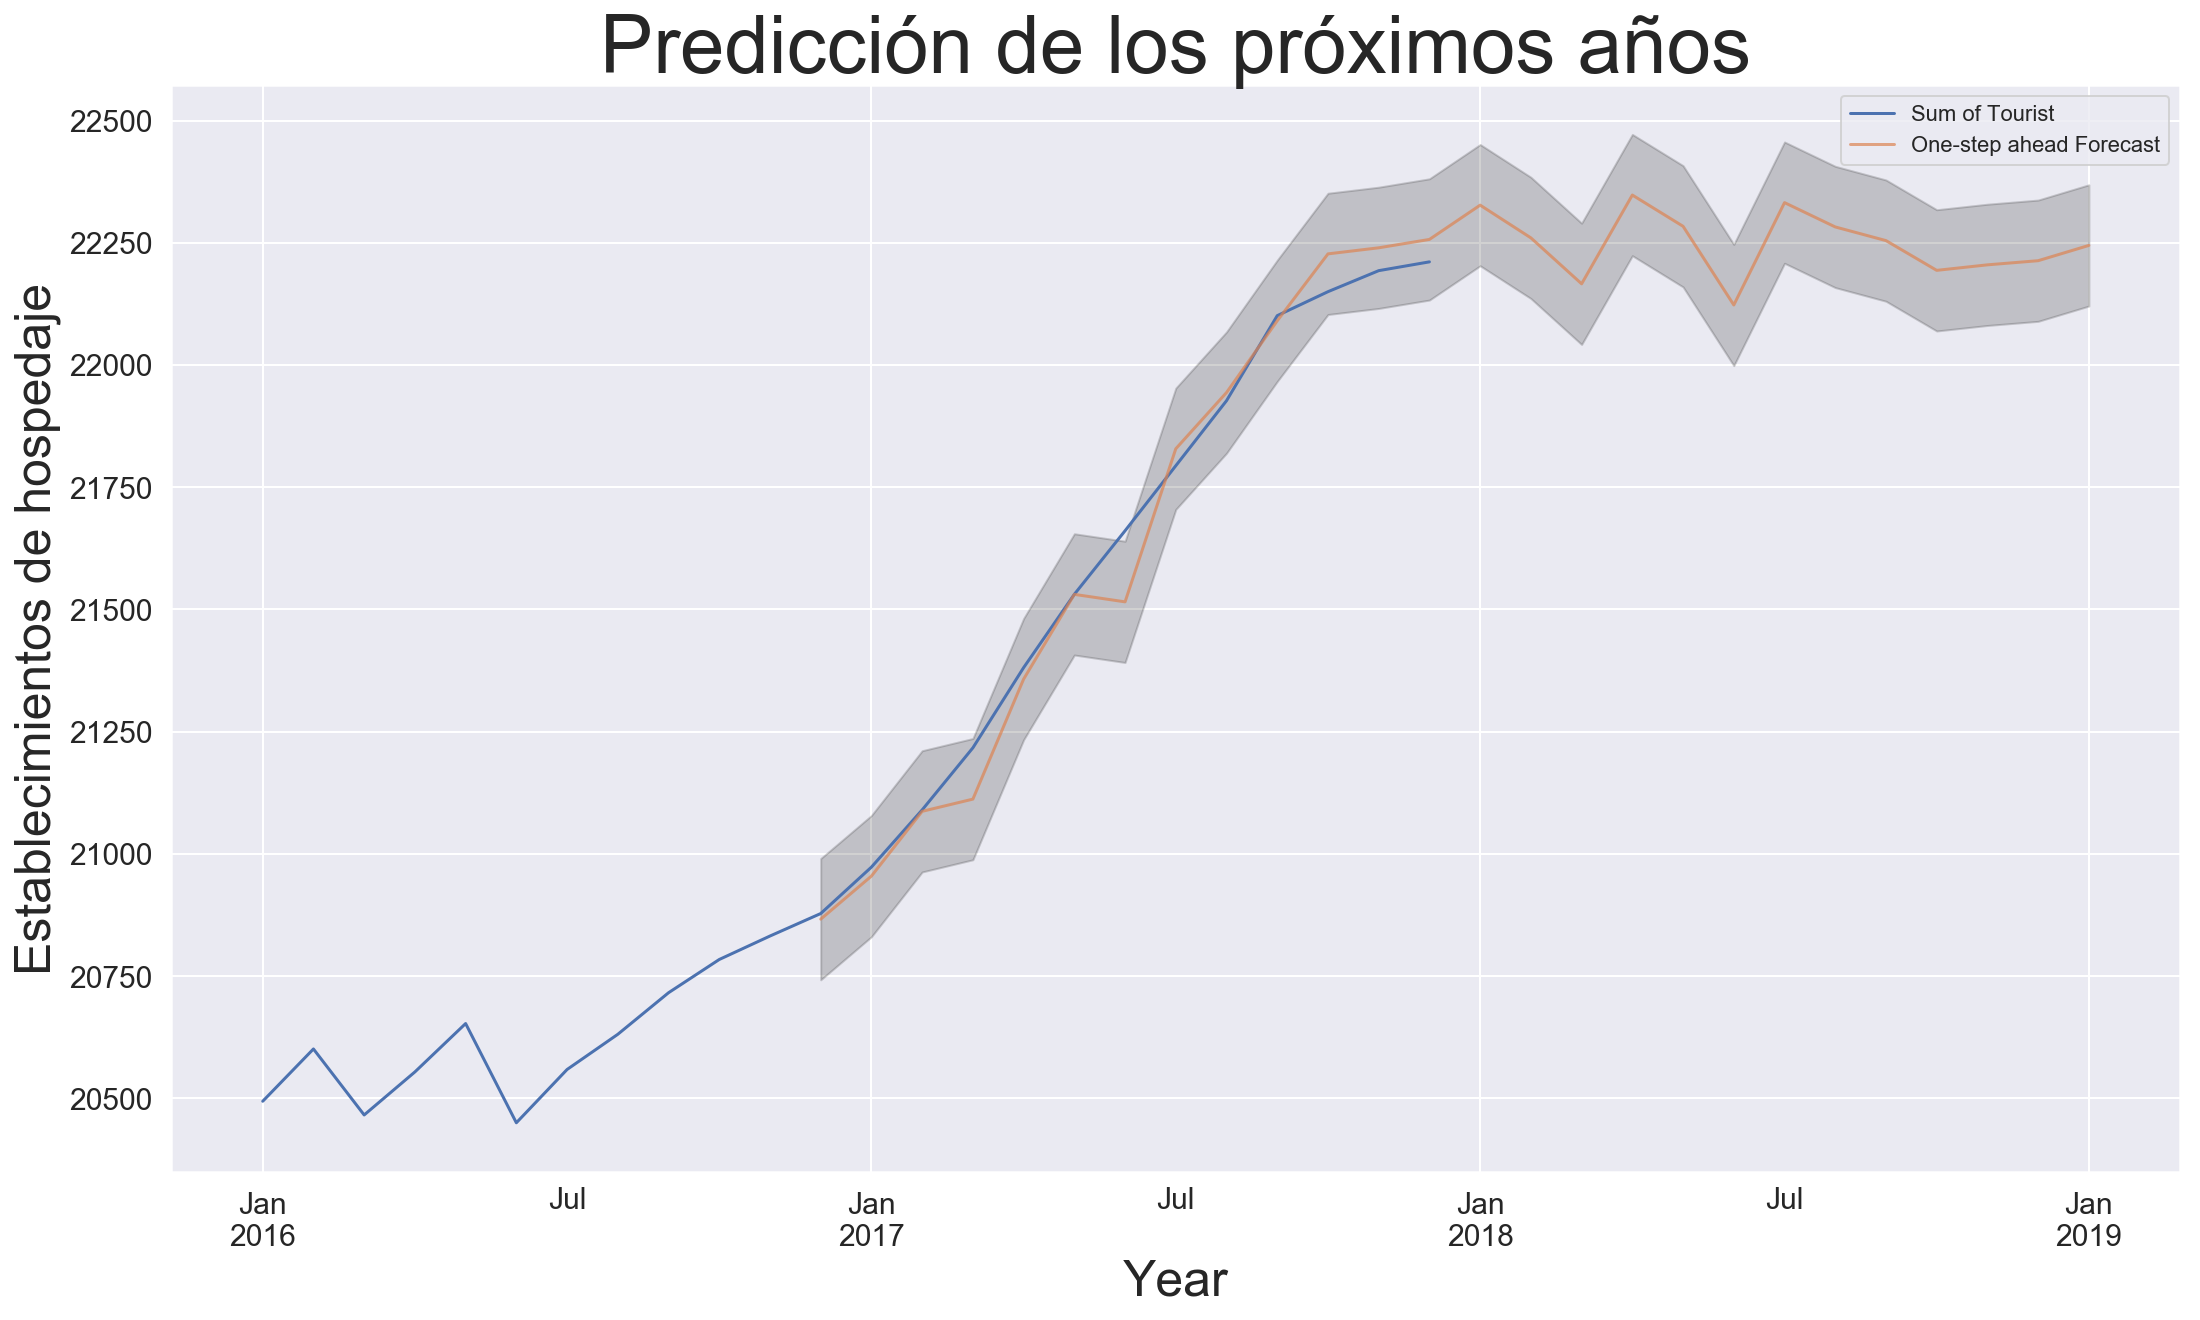

In [269]:
predict_plot('rptaniomesp_a.xls','Establecimientos de hospedaje')

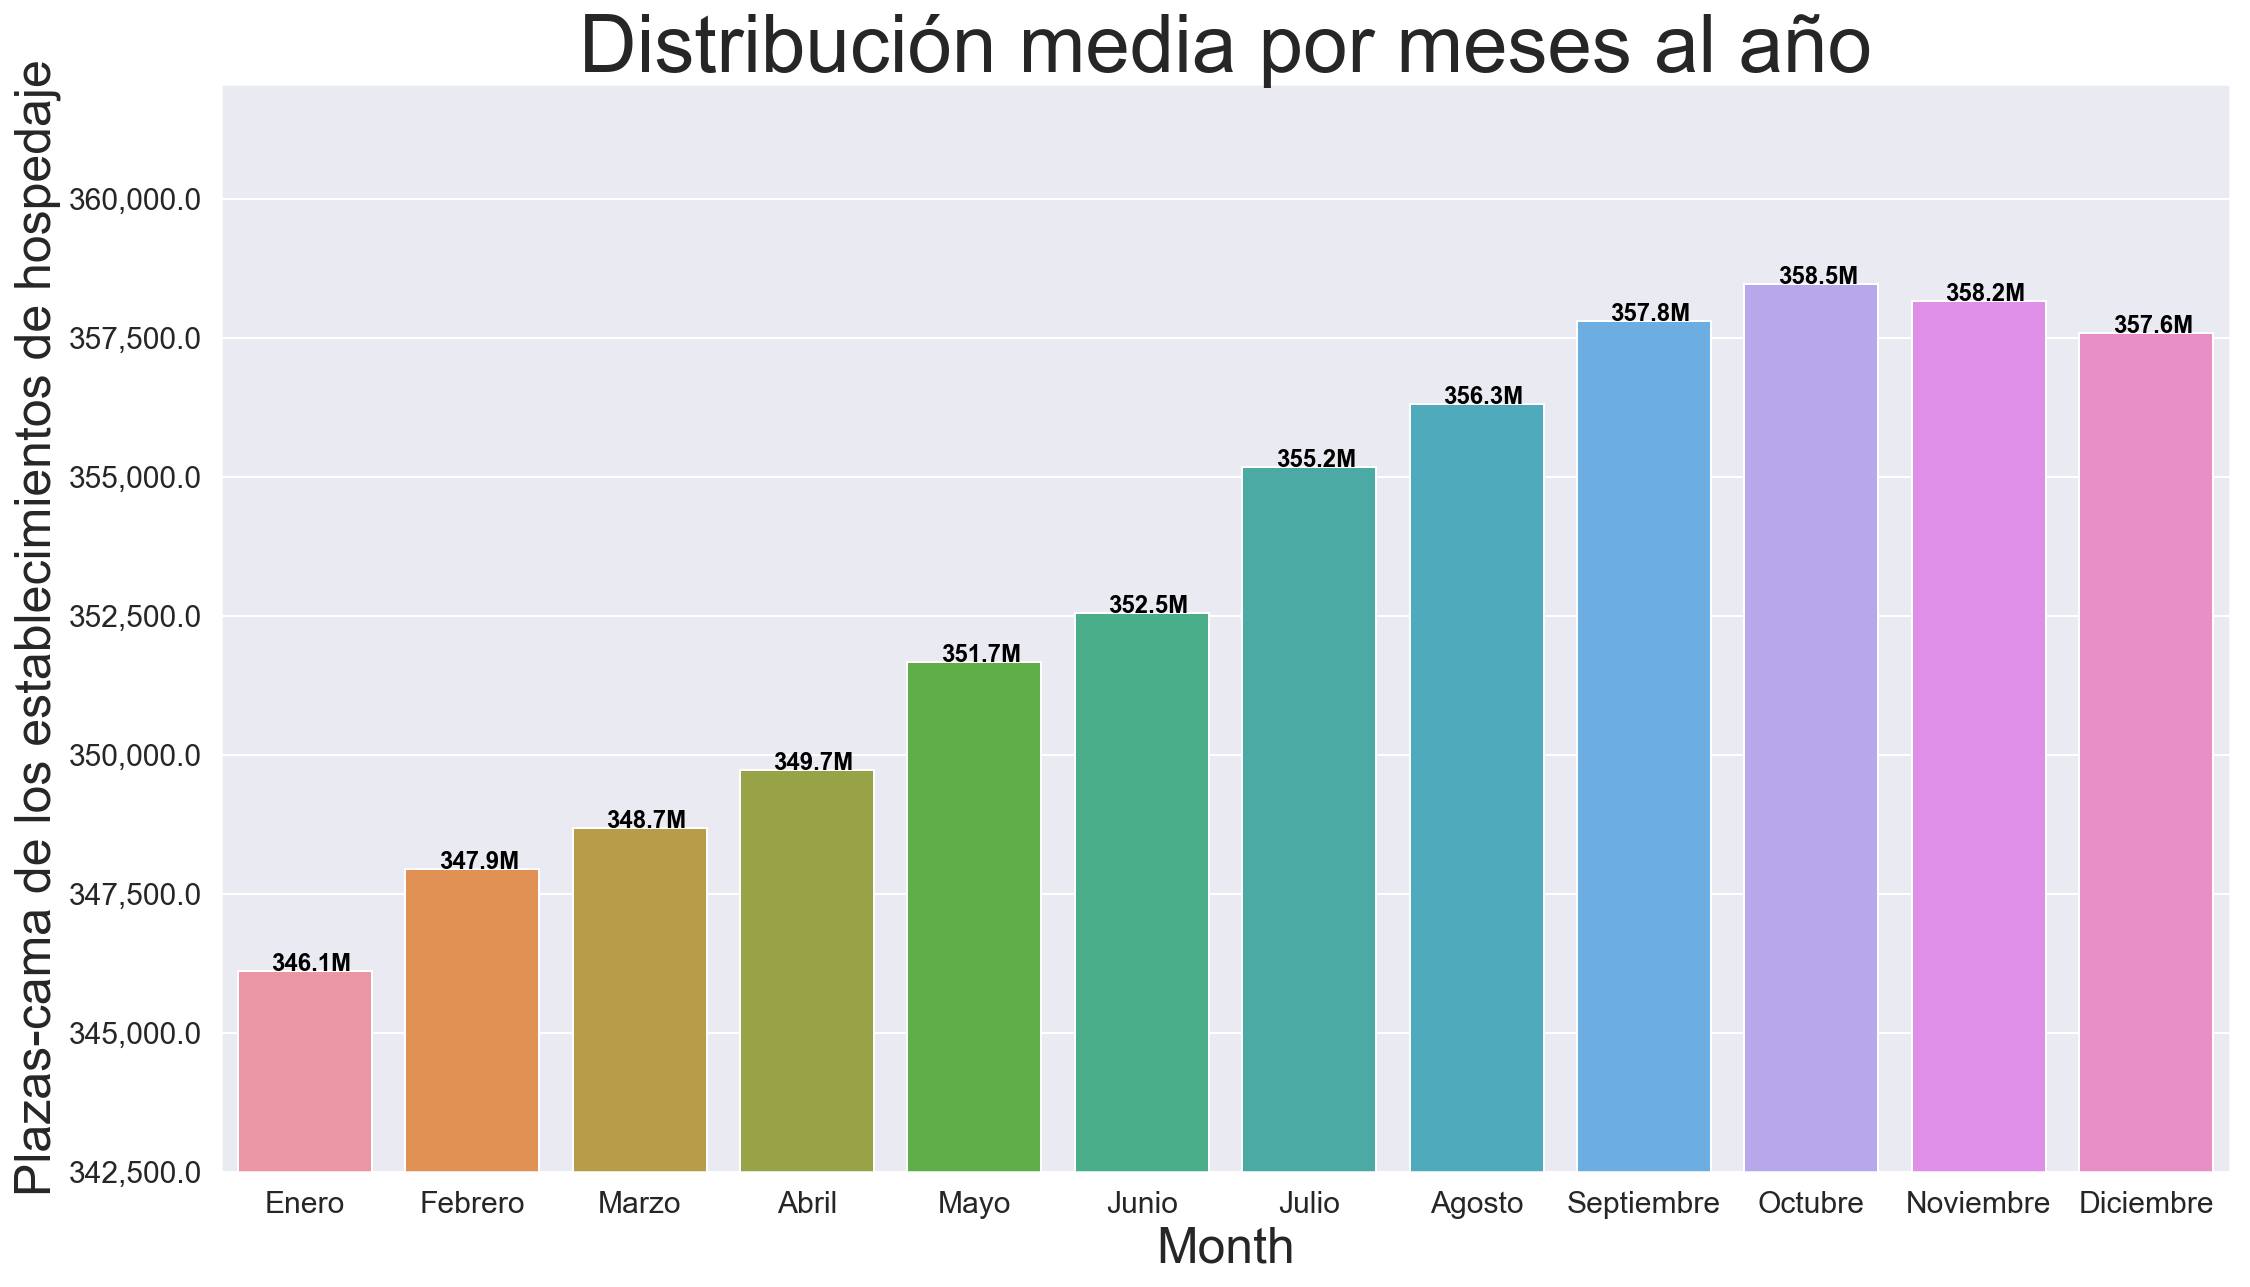

In [314]:
show_descriptive_data_by_month('rptaniomesp_b.xls','Plazas-cama de los establecimientos de hospedaje')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2882      0.661      0.436      0.663      -1.007       1.583
ma.L1         -0.2168      0.708     -0.306      0.760      -1.605       1.172
ar.S.L12      -0.5621      0.050    -11.133      0.000      -0.661      -0.463
sigma2      3.234e+06   2.14e+05     15.110      0.000    2.81e+06    3.65e+06


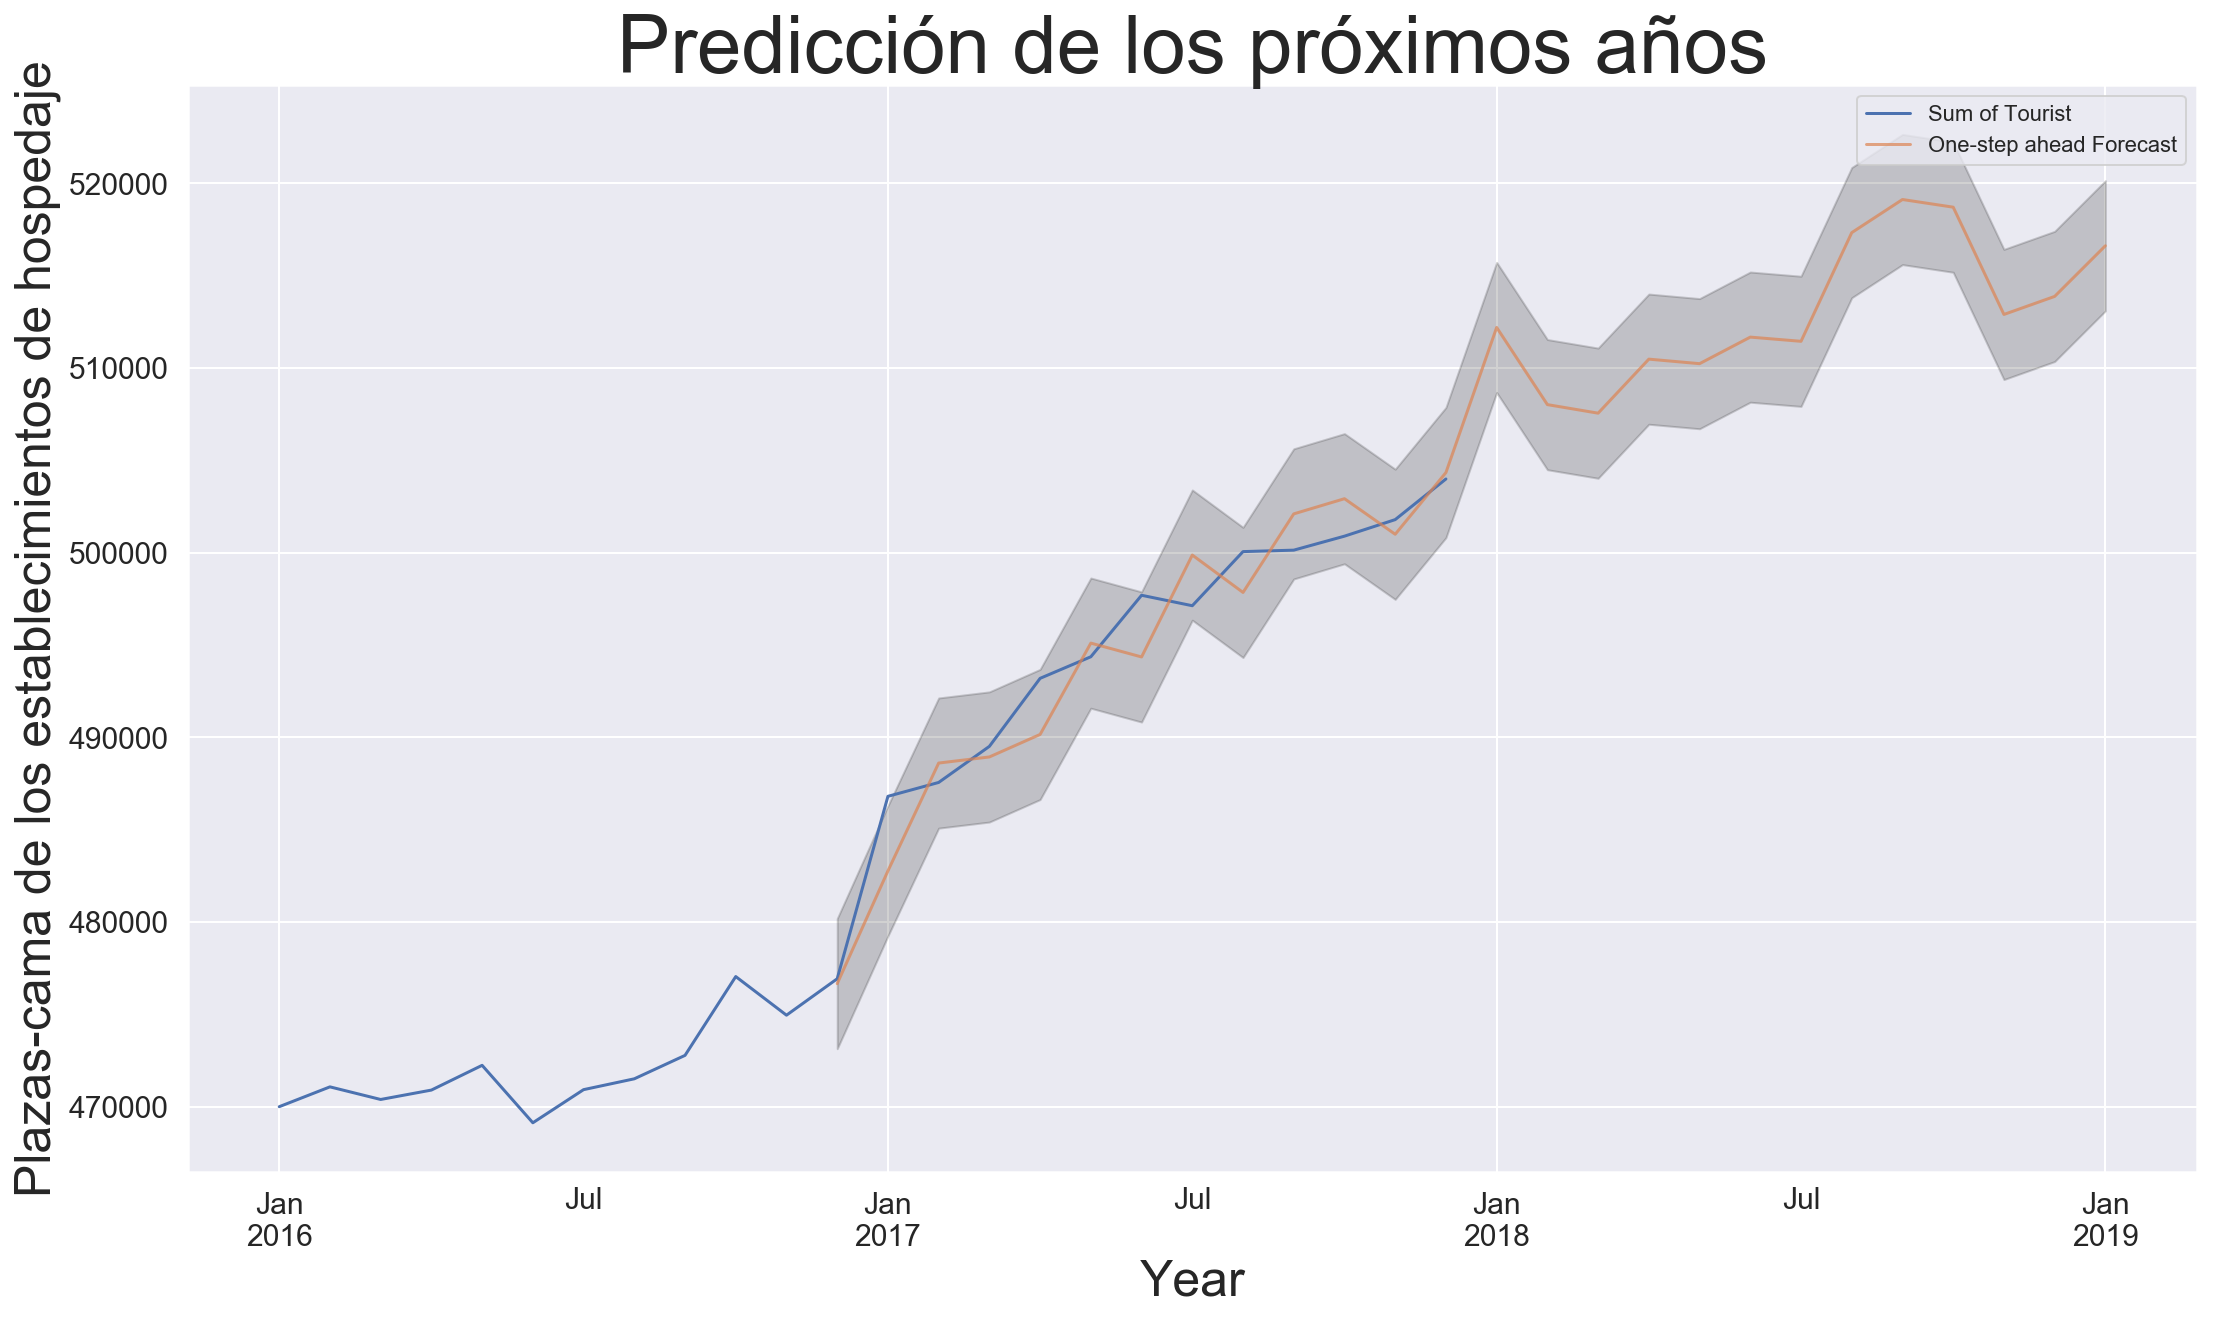

In [270]:
predict_plot('rptaniomesp_b.xls','Plazas-cama de los establecimientos de hospedaje')

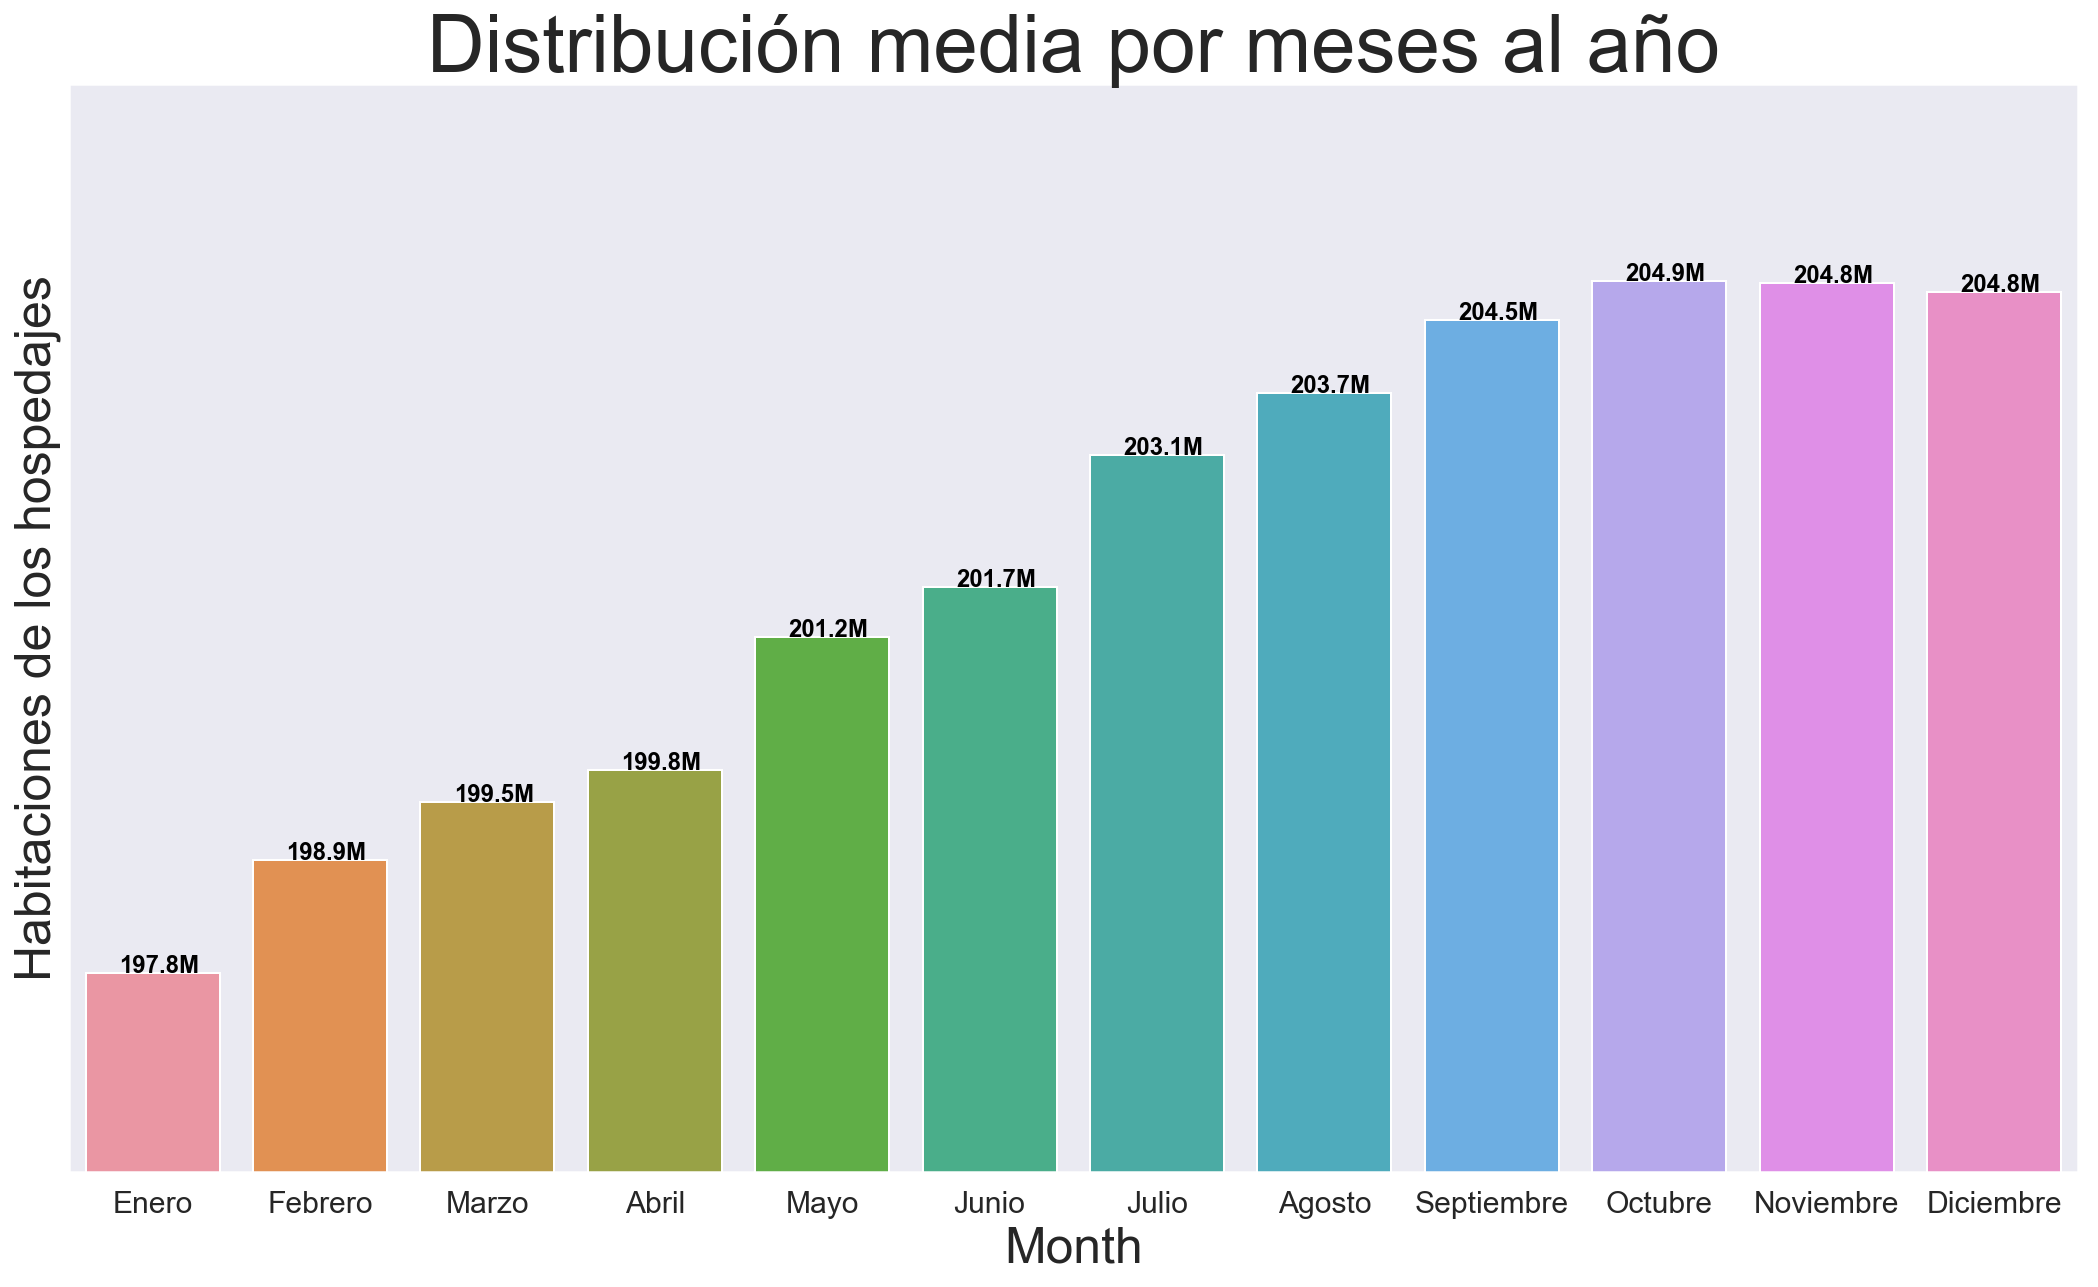

In [310]:
show_descriptive_data_by_month('rptaniomesp_c.xls','Habitaciones de los hospedajes')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3434      0.370      0.929      0.353      -0.381       1.068
ma.L1         -0.2457      0.429     -0.573      0.566      -1.086       0.594
ar.S.L12      -0.6096      0.043    -14.287      0.000      -0.693      -0.526
sigma2      8.935e+05   5.79e+04     15.439      0.000     7.8e+05    1.01e+06


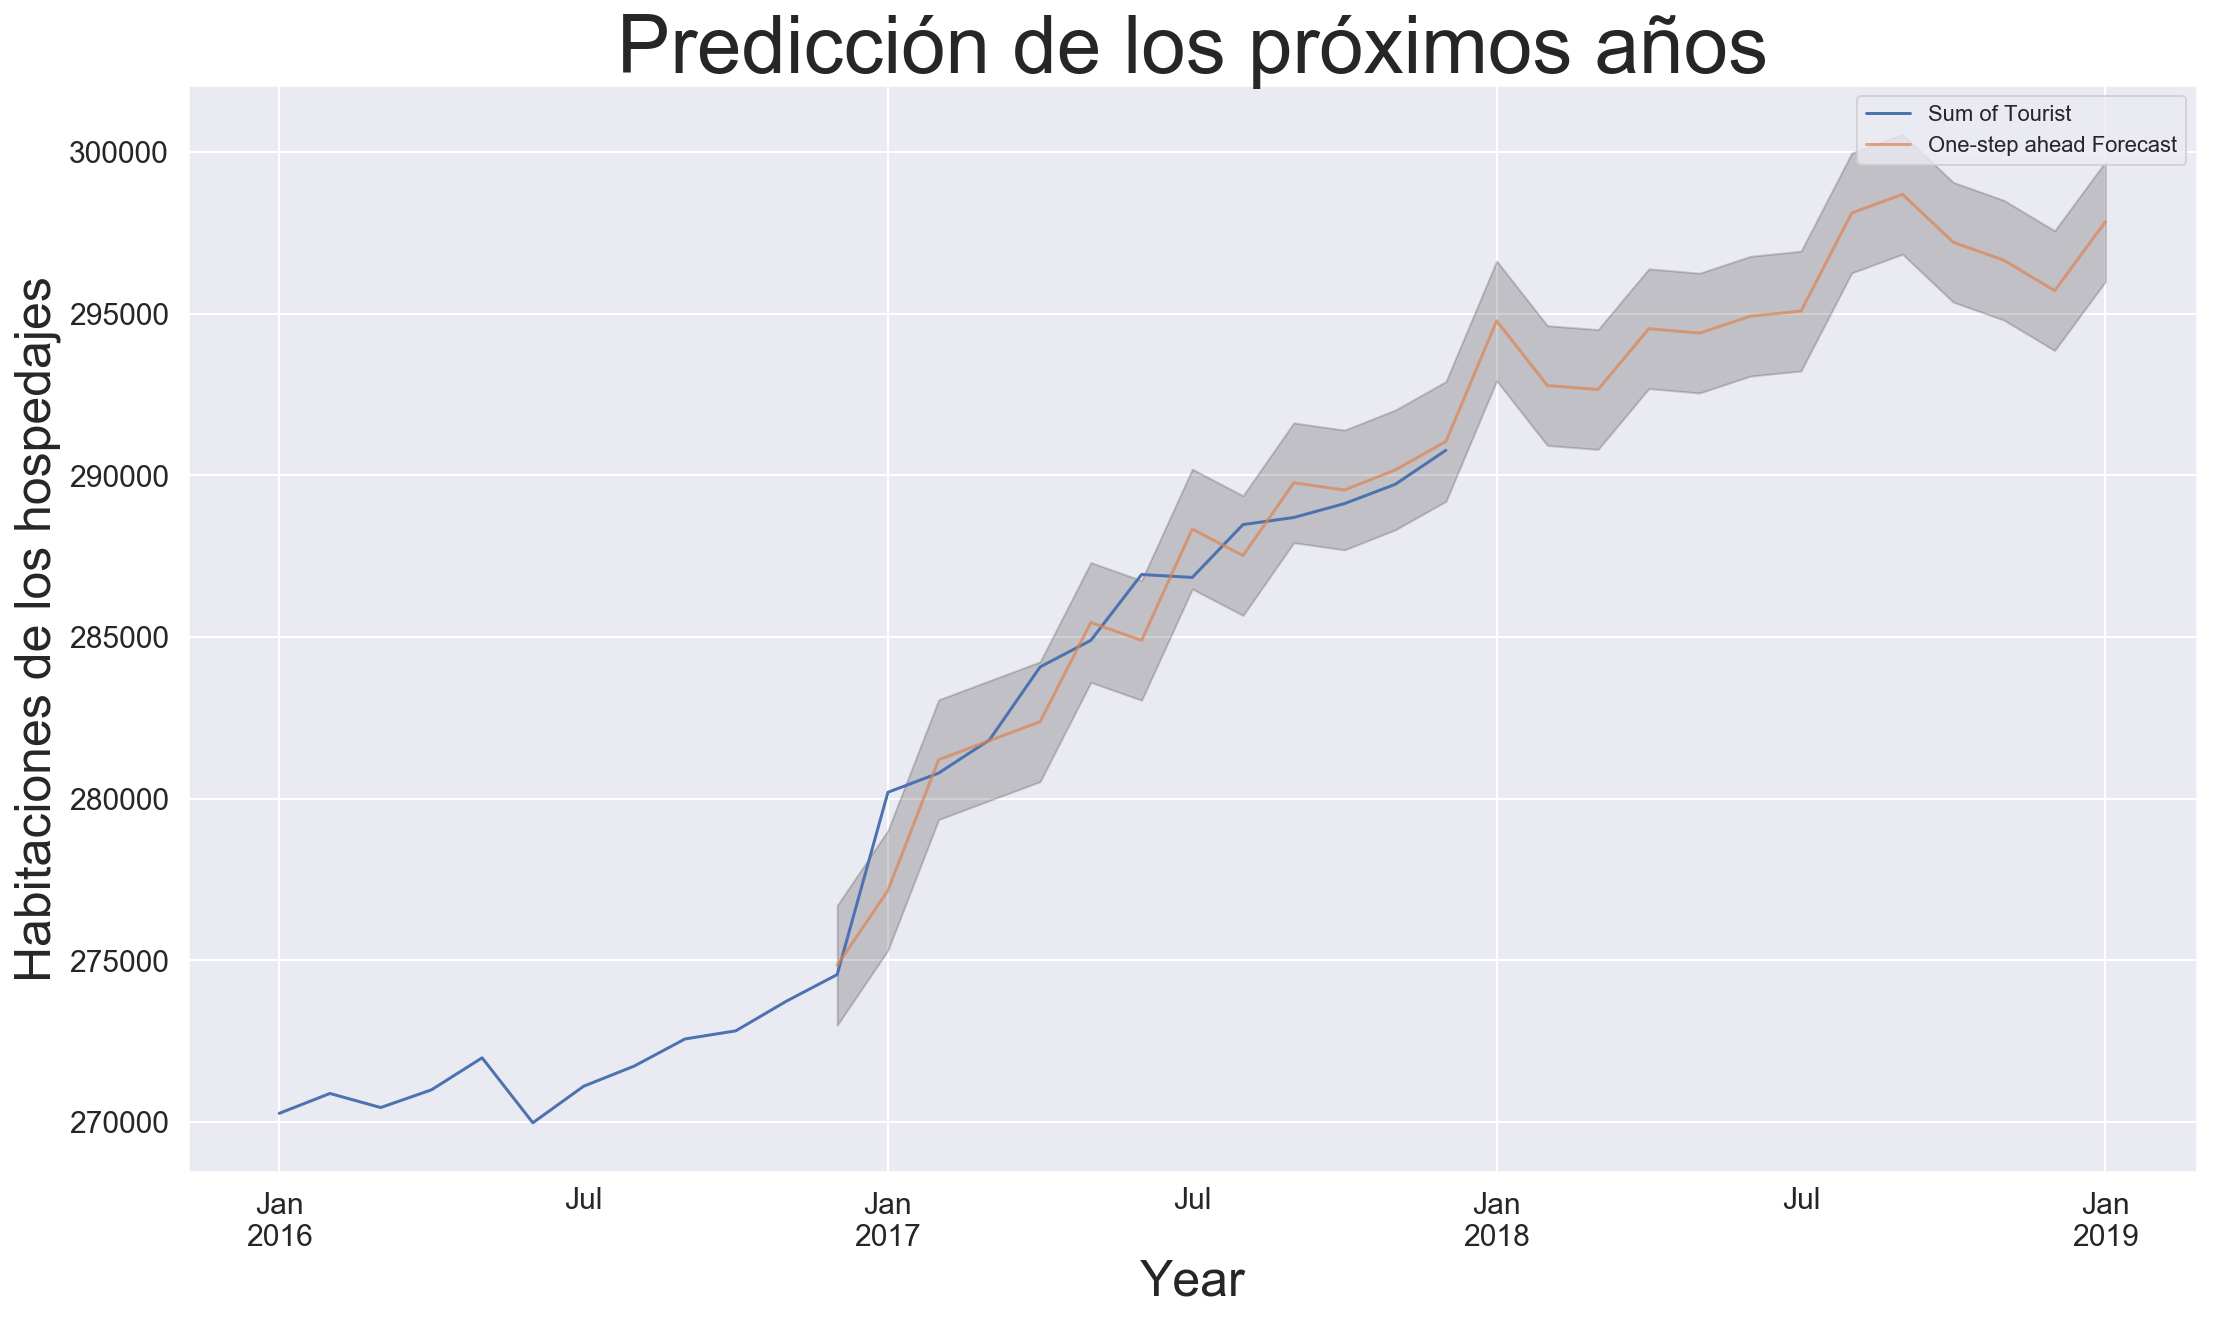

In [271]:
predict_plot('rptaniomesp_c.xls','Habitaciones de los hospedajes')